In [1]:
from __future__ import division

import os

import numpy as np

from glob import glob

import reduce_dblspec

import astropy

from astropy.io import fits
from astropy import units as u
from astropy.table import Table

from astropy import modeling
from astropy.modeling import models, fitting

from astropy import constants as cnst
%matplotlib inline
from matplotlib import pyplot as plt
import pipeline
from photutils import centroid_com
from astropy import units as u
from astropy import constants as const
import pandas as pd
import math as m
from scipy.optimize import curve_fit
from scipy import asarray as ar,exp
from astropy import constants as const
from astropy.stats import sigma_clip
from astropy.modeling.models import custom_model
from astropy.modeling.fitting import LevMarLSQFitter


from astropy.visualization import quantity_support
quantity_support() #not sure about this line but stackoverflow...try w/o it later

from matplotlib import pyplot as plt

In [2]:
#amending pipeline code to get sky subtraction separate from 1d spec

def sky_subtract2D(comb,skyaps,model):    
    #plotting 2D to get skyaps right around the target
    plt.figure(figsize=(10,25)) #setting up fig size
    value = model[1]
    if model == 'linear':
        subimg, models = comb.subtract_sky(skyaps, skymodel=modeling.models.Linear1D(1,0)) #(1,0)
    elif model == ('poly',value):
        subimg, models = comb.subtract_sky(skyaps, skymodel=modeling.models.Polynomial1D(value)) #Linear1D(1/10,10)) #(1,0)
    elif model == ('combined',value):
        mymodel=(modeling.models.Polynomial1D(value) + modeling.models.Linear1D(1,0))
        subimg, models = comb.subtract_sky(skyaps, skymodel=mymodel)
    elif model == None:
        subimg, models = comb.subtract_sky(skyaps, skymodel=None)#subtracts mean
    else:
        print ("Model type or polynomial degree not recognized")
    return (subimg, comb, models)    #subtracted2D, original, fitted models per row


def show_image(comb, **kwargs): #comb-self
        """
        Matplotlib imshow of this image

        transpose image for blue side unless transpose=False is given

        if log=True is given,the whole image will be linearly rescaled to 1-100
        before log-ifying, possibly be vmin/vmax
        """
        from matplotlib import pyplot as plt

        kwargs.setdefault('interpolation', 'nearest')
        kwargs.setdefault('transpose', self.side=='blue')

        if kwargs.pop('log', False):
            safedata = self.data[np.isfinite(self.data)]
            #use vmin and vmax to rescale  1-100
            lmin = kwargs.pop('logmin', None)
            lmax = kwargs.pop('logmax', None)
            mx = lmax if lmax else np.max(safedata)
            mi = lmin if lmin else np.min(safedata)
            rescaleddata = ((comb.data - mi) / (mx - mi)) #comb-self
            rescaleddata[rescaleddata>1] = 1
            rescaleddata[rescaleddata<0] = 0
            d = np.log10(rescaleddata*99.+1.)
        else:
            d = comb.data #comb-self
        if kwargs.pop('transpose'):
            d = d.T
        res = plt.imshow(d, **kwargs)
        return res

   #defining a function will use later to extract target's 1D spectrum from whole 2D data file 
def extract_spectrum(side, subtracted_2d, aperture):
        """
        Extract a 1D spectrum the "simple" (non-Horne) way
        
        Parameters
        ----------
        aperture : 2-tuple
            The edges of the aperture along the spatial axis
            
        Returns
        -------
        spectrum : array
            A 1D extracted spectrum with the *sum* of the flux.
        unc : 1D array
            The flux uncertainty matching the extracted spectrum
        """

        apslc = aperture if isinstance(aperture, slice) else slice(*aperture)
        if side == 'red':
            d = subtracted_2d.data
        elif side == 'blue':
            d = subtracted_2d.data.T
        else:
            raise ValueError('unrecognized side ')
        spec = np.sum(d[apslc], axis=0)
        unc = np.sum(d[apslc]**2, axis=0) ** 0.5
        unsum_spec = d[apslc]
        return spec, unc, unsum_spec #spec-1D spectrum for target
#spec is summed data for each pixel column(wl) within the spec aps range

In [3]:
#Finding all data file for specific target and doing instrumentation noise subtraction
flatid = 'DomeFlat'
atlasfiles_red = fits.open('henear.fits') #NOAO atlas  #RED side 
atlasfiles_blue = fits.open('fear.fits') #NOAO atlas #BLUE side 
linelist_red = reduce_dblspec.HENEAR_LINE_LIST #RED side
linelist_blue = reduce_dblspec.FEAR_LINE_LIST #BLUE side

############### possible changes to change targets
##################################################
arcfiles_red10 = 'DoubleSpec/20170519/red0012.fits' #henear ARC lamp #1.0" slit #RED side
arcfiles_blue10 = 'DoubleSpec/20170519/blue0012.fits' #fear ARC lamp #1.0" slit #BLUE side
targetID = '65565541728490-Gilgamesh'
all_side_files_red = 'DoubleSpec/20170519/red*.fits'#RED side
all_side_files_blue = 'DoubleSpec/20170519/blue*.fits'#BLUE side
#target = fits.open('DoubleSpec/20170519/red0089.fits') #use these to get targetid
#target[0].header
##################################################

/Users/dee/Desktop/data_pipeline/reduce_dblspec.py:256: RuntimeWarning: invalid value encountered in sqrt
  unc = (result/self.header['GAIN'] + self.unc[tsl]**2)**0.5


used atlas plot limits for Red side


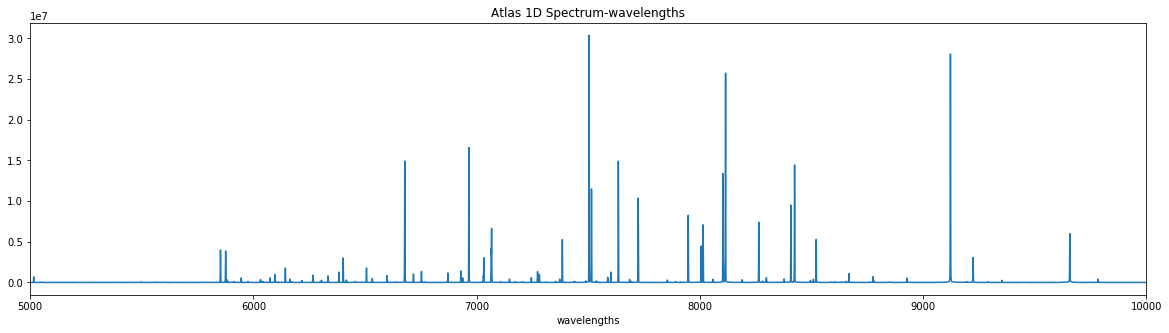

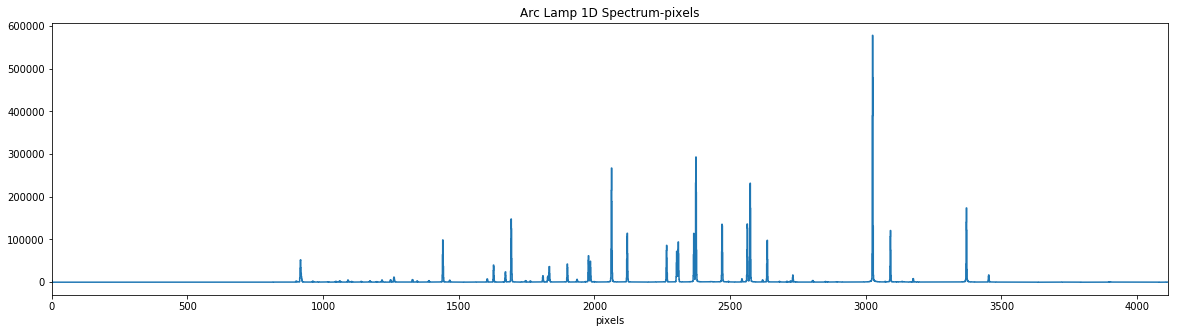

In [4]:
#creating a ds _ part one

#plotting arc lamp pixel data and atlas wl data to match lines in next cell
specset_red = pipeline.dispersion(all_side_files_red, atlasfiles_red, arcfiles_red10, linelist_red,flatid)

/Users/dee/miniconda3/lib/python3.6/site-packages/matplotlib/cbook/deprecation.py:107: MatplotlibDeprecationWarning: Using pyplot.axes(ax) with ax an Axes argument is deprecated. Please use pyplot.sca(ax) instead.
  warnings.warn(message, mplDeprecation, stacklevel=1)


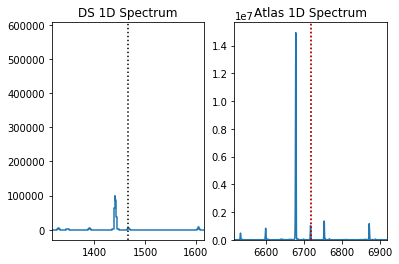

In [5]:
#creating a ds _ part two

#use above plots to enter guesses of matching lines
pipeline.guess_plot(1466,6717,specset_red) #(arc-PIX-guess, atlas-WL-from-linelist)

#collect guesses here ~5 seems good
pixel_guesses = [3024,2373,2062,1672,3370,1466]
atlas_lines = [9122.9674,8115.311,7635.106,7032.4131,9657.7863,6717.043]
guesses = list(zip(pixel_guesses, atlas_lines)) #must be tuples

/Users/dee/Desktop/data_pipeline/reduce_dblspec.py:256: RuntimeWarning: invalid value encountered in sqrt
  unc = (result/self.header['GAIN'] + self.unc[tsl]**2)**0.5


chose ds for redside
chose guesses for redside
Skipping line HeI at wl=3187.745 - out of wl min/max
Skipping line ArII at wl=3307.2283 - out of wl min/max
Skipping line ArI at wl=3319.3446 - out of wl min/max
Skipping line ArII at wl=3350.9243 - out of wl min/max
Skipping line HeI at wl=3354.55 - out of wl min/max
Skipping line ArI at wl=3373.4823 - out of wl min/max
Skipping line ArII at wl=3376.4359 - out of wl min/max
Skipping line ArII at wl=3388.5309 - out of wl min/max
Skipping line NeII at wl=3397.866 - out of wl min/max
Skipping line ArI at wl=3406.1804 - out of wl min/max
Skipping line ArII at wl=3414.4583 - out of wl min/max
Skipping line NeI at wl=3417.9035 - out of wl min/max
Skipping line ArII at wl=3421.6107 - out of wl min/max
Skipping line ArII at wl=3454.0952 - out of wl min/max
Skipping line ArII at wl=3464.1272 - out of wl min/max
Skipping line NeI at wl=3472.5711 - out of wl min/max
Skipping line ArII at wl=3476.7474 - out of wl min/max
Skipping line ArII at wl=3480

Failed to find line HeI at wl=7281.349: "Guessed line's peak to base ratio is 7.032109457162515, which is less than 10"
Failed to find line ArI at wl=7353.293: "Guessed line's peak to base ratio is 1.658465011234017, which is less than 10"
Failed to find line ArI at wl=7372.1184: "Guessed line's peak to base ratio is 1.8965815375008566, which is less than 10"
Found line ArI at wl=7383.9805
Clipped 0 lines
Failed to find line NeI at wl=7488.8712: "Guessed line's peak to base ratio is 2.54705220294689, which is less than 10"
Found line ArI at wl=7503.8691
Clipped 0 lines
Found line ArI at wl=7514.6518
Clipped 0 lines
Failed to find line NeI at wl=7535.7739: "Guessed line's peak to base ratio is 2.2797688226410067, which is less than 10"
Failed to find line NeI at wl=7544.0443: "Guessed line's peak to base ratio is 1.4990809349450942, which is less than 10"
Failed to find line KrI at wl=7587.413: "Guessed line's peak to base ratio is 0.9648946538339258, which is less than 10"
Failed to fi

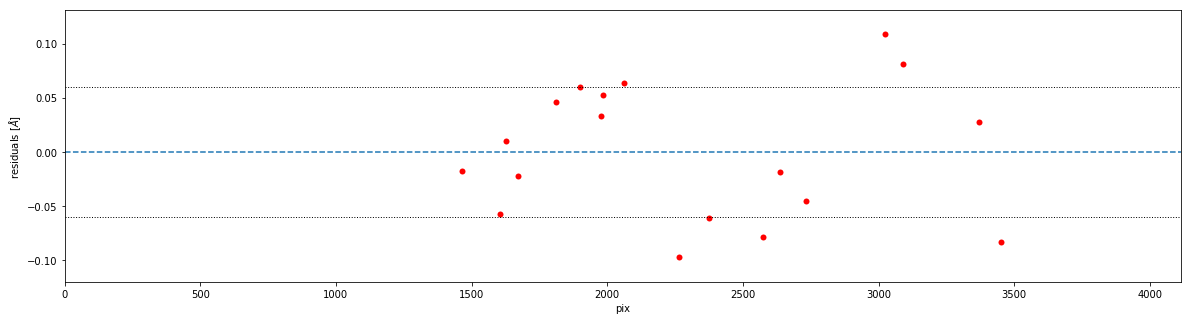

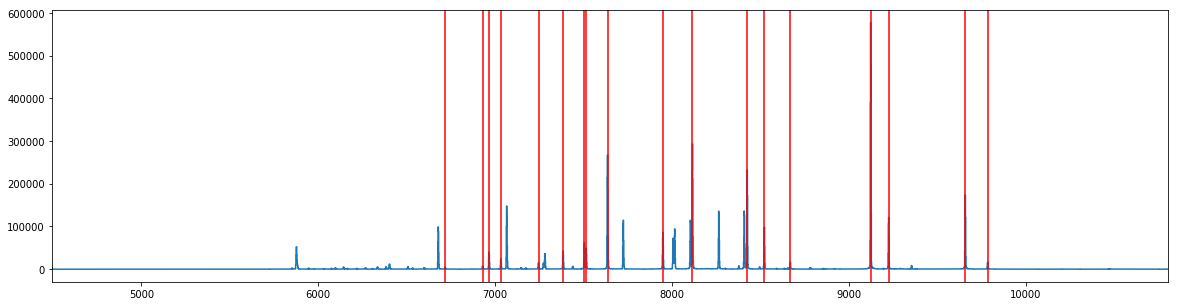

In [6]:
#creating a ds _ part three

ds_red = pipeline.goodness_of_matches(arcfiles_red10, guesses, all_side_files_red, atlasfiles_red, linelist_red, flatid);
#this is the final red side ds

/Users/dee/Desktop/data_pipeline/reduce_dblspec.py:88: UserWarning: ROISEC is not one of the values this pipeline assumes.It may not work right where specific values are used (e.g., creating master flats
  warn("ROISEC is not one of the values this pipeline assumes."
/Users/dee/Desktop/data_pipeline/reduce_dblspec.py:256: RuntimeWarning: invalid value encountered in sqrt
  unc = (result/self.header['GAIN'] + self.unc[tsl]**2)**0.5


used atlas plot limits for Blue side


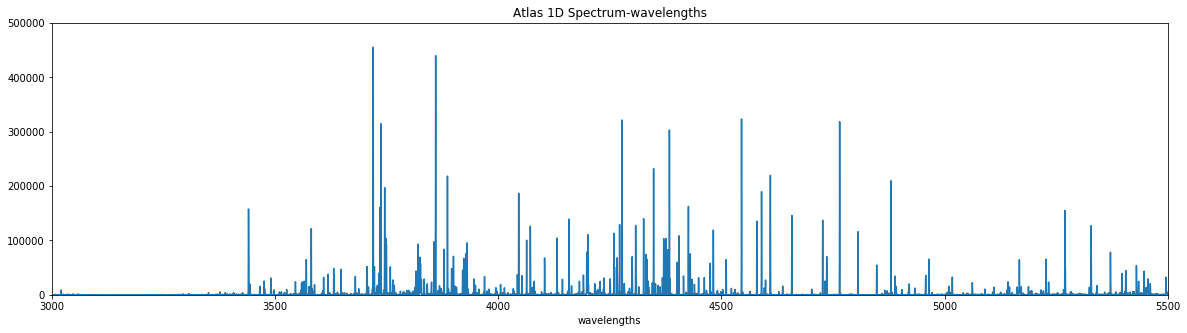

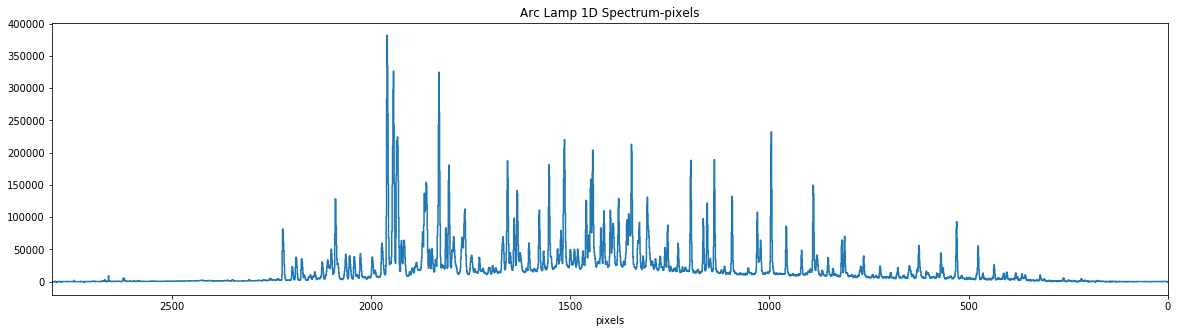

In [7]:
#creating a ds _ part one

#plotting arc lamp pixel data and atlas wl data to match lines in next cell
specset_blue = pipeline.dispersion(all_side_files_blue, atlasfiles_blue, arcfiles_blue10, linelist_blue,flatid)

/Users/dee/miniconda3/lib/python3.6/site-packages/matplotlib/cbook/deprecation.py:107: MatplotlibDeprecationWarning: Using pyplot.axes(ax) with ax an Axes argument is deprecated. Please use pyplot.sca(ax) instead.
  warnings.warn(message, mplDeprecation, stacklevel=1)


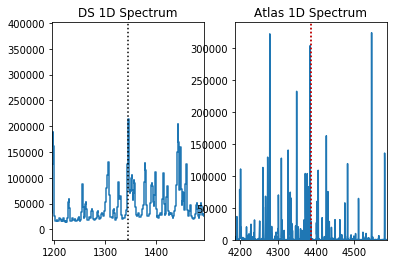

In [8]:
pipeline.guess_plot(1345,4384.8646,specset_blue) #(px,wl)

#collect guesses here but comment them out to see output of matches from line above
pixel_guesses_blue10 = [994,1197,1443,1459,1640,1803,1957,1972,2088] #,1657/6, 1829,,2218, 2088,1345
atlas_lines_blue10 = [4764.8646,4545.0519,4277.5282,4259.3619,4063.5939,3886.2820,3719.9346,3705.5657,3581.1925] #,4045.8130,3859.9114,3443.8762,3581.1925,4384.8646
#529,1764
#5269.5366,3930.2962
guesses_blue10 = list(zip(pixel_guesses_blue10, atlas_lines_blue10)) #making tuples to pass into fcn later

In [9]:
#creating a ds _ part three-------except blue side sucks

#ds_blue = pipeline.goodness_of_matches(arcfiles_blue10, guesses, all_side_files_blue, atlasfiles_blue, linelist_blue, flatid);
#this is the final blue side ds 

/Users/dee/Desktop/data_pipeline/reduce_dblspec.py:256: RuntimeWarning: invalid value encountered in sqrt
  unc = (result/self.header['GAIN'] + self.unc[tsl]**2)**0.5


4 target files located
choose 2D spec for redside
choose 1D target spec axis limits for redside


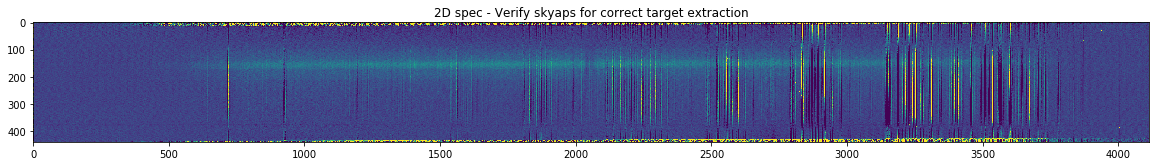

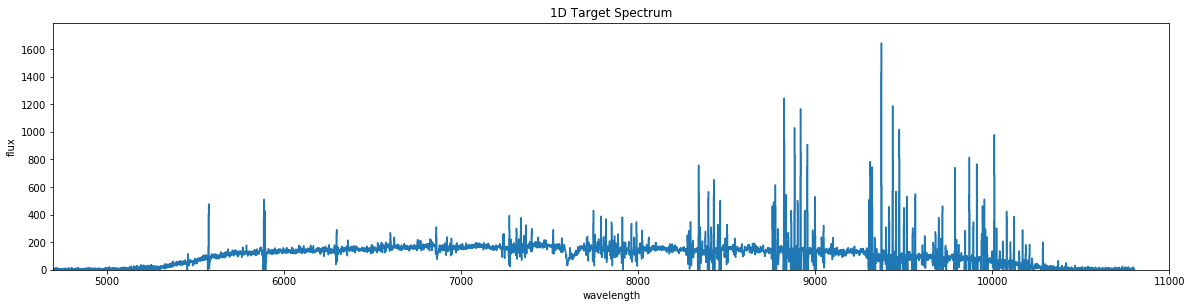

In [10]:
#RED side SPECTRUM

#define relevant pixel spatial regions
#####################################################
skyaps_red=[(60,90),(340,430)]#[(20,95),(275,320)]#spatial regions above & below target to estimate sky emissions
model_red='linear'#('poly',2)# #estimating sky line tilt
specaps_red = (145,160)#(140,170)#(100,260)##WHAT IS THIS AGAIN? target spatial region? area btwn skyaps??
#####################################################

#helps color scale of 2D
vmax = 40
vmin = -10

#subtracts sky lines & stacks target images to extract 1D
target_flux_red, target_unc_red, target_comb_red = pipeline.sky_subtract(targetID, skyaps_red, ds_red, all_side_files_red, atlasfiles_red ,all_side_files_red, flatid, specaps_red, vmax, vmin, model_red)

In [11]:
#skipping blue til fix ds

In [12]:
#isolates the sky-subtracted 2D spectrum

#choose best emission line side
##############################################
best_emission_comb = target_comb_red
best_emission_skyaps = skyaps_red
best_emission_model = model_red
##############################################

#sky-subtracting 2D
subimg2, comb2, fitmodels = sky_subtract2D(best_emission_comb, best_emission_skyaps, best_emission_model)
#subimg2 is sky-subtracted, instumentation noise subtracted, stacked data
#comb2 is original instrumentation noise subtracted, stacked data
#fitmodels is sky lines fitted to 'model' type

<Figure size 720x1800 with 0 Axes>

FLUX_DATA is the target's entire 2D SPEC WILL WANT TO USE - ENTIRE REDSIDE (minus first 10 wls)
flux data shape: (168, 4104)
NOTE 10 spectral PIXELS missing  WL_PIX_CORRECTION DEFINED HERE!!!!!! 


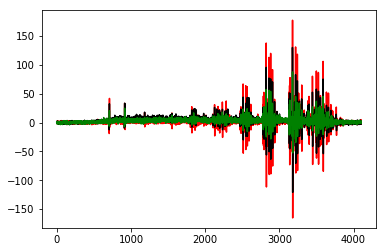

In [13]:
#PART ONE -----------------prep for centroiding

#first need to get target only 2D aka(1D spectrum for each spatial pixel row in the 2D target data)
############################################
target_aperature=(96,263) #target location #best location osscillated crazy even one pixel more out 
############################################
space_pix_correction = target_aperature[0]

flux_data=[] #to hold target only 2d spec
apslc = np.arange(target_aperature[0],target_aperature[1]+1,1) #list of rows to extract spec from
#np.shape(subimg2.data)#(440, 4114)


#extracting target spec from whole 2d spec
for i in apslc:
    spec = subimg2.data[i]#subimg2 is sky-subtracted 2D spec #this is every row's spec...
    
    #need to change if suming multiple pixel rows
    spec = spec[10::] #chops first 10 flux values in spectral (wl) direction-crazy osscillations
    flux_data.append(spec) #collects every row's spec within the target location
flux_data=np.array(flux_data)   
#need to find a way to sum over diff ranges of apslc 

#######################################################
#defining spectral correction factor (try to fit this into loop above later on)
wl_pix_correction = 10 #wont affect spatial pix values, only amount of flux but thats negligible
#######################################################

#just to visually confirm
plt.plot(flux_data[145],color='r')#near galaxy center
plt.plot(flux_data[75],color='k') #near galaxy edge
plt.plot(flux_data[24],color='g')#near opposite galaxy edge

#conclusions
print("FLUX_DATA is the target's entire 2D SPEC WILL WANT TO USE - ENTIRE REDSIDE (minus first 10 wls)" )
print('flux data shape:', np.shape(flux_data)) #(226, 4104)
print('NOTE 10 spectral PIXELS missing ', 
      'WL_PIX_CORRECTION DEFINED HERE!!!!!! ')

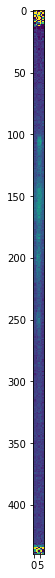

In [14]:
#PART TWO ----------------------determining best emission line pixel range

#using FULL ccd pixel range
################################################################
testingthis=subimg2.data[:,1388:1397] #[space,wl]for RED [wl,space]for BLUE
#conclusions
bestline_range_fullccd = (1388, 1397) #same as testing this
bestline_range_correction = (1378,1387) #after w/e wl cuts
#################################################################

vmin=-10
vmax=45
plt.figure(figsize=(10,10))
plt.imshow(testingthis,vmin=vmin,vmax=vmax)#add in ,aspect='auto', to get square pixels

Text(0.5,1,'h-alpha centroids in pixel values')

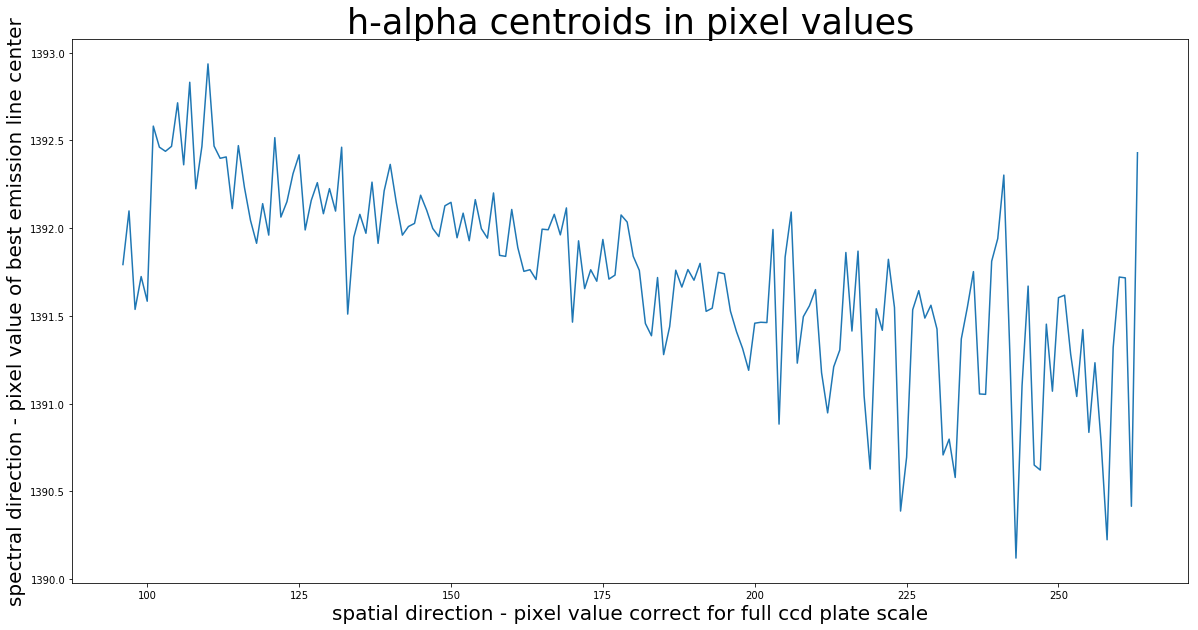

In [15]:
#PART THREE ------------------------------does the centroiding

#applies DS using full ccd pixel range 
#####################################################################
wl = np.array(ds_red.pixtowl(np.arange(len(subimg2.data[::][0]))))
#getting corresponding flux & wl values in best emission line region of 2D
wl_shorter2 = wl[1388:1397] #isolate wl around h-alpha using 'bestline_range_fullccd'
flux_data_short = flux_data[:,1378:1387] #use 'bestline_range_correction' range
#####################################################################


centroids_pix = []
mylist_ys2 = []
gfit_vals = []
stddev = []
means=[]
means_unc=[]




#gets halpha centroids/gaussians/uncertainities in target gal's range

for row in flux_data_short: 
    
    #calculates centroids per row
    flux_fake2d2 = row[np.newaxis, :] #makes each row array into a fake2d
    centroid_ys, centroid_xs = centroid_com(flux_fake2d2)#finds center(x,y) of best emission line for each row array
    mylist_ys2.append(centroid_ys)
    #print(centroid_xs, centroid_ys)
    centroids_pix.append(centroid_xs) #collects all best emission line centroids per row
    
    #calculating errors per row via gaussian fit
    x = ar(range(len(row)))
    y = row
    mean = centroid_xs
    g_init = models.Gaussian1D(amplitude=max(y), mean=mean, stddev=2.)
    fit_g = fitting.LevMarLSQFitter()
    gaussian = fit_g(g_init, x, y)
    gfit_vals.append(gaussian)
    stddev.append(gaussian.stddev.value)
    means.append(gaussian.mean.value)

    #trying to get uncertainities per row via covariance matrix
    gaussian.param_cov = fit_g.fit_info['param_cov']
    means_unc.append(fit_g.fit_info['param_cov'])#matrix fix
    #means_unc.append(fit_g.fit_info['param_cov'][1][1]) #if gives errors use matrix fix
    
    
#end of for loop  - making things into arrays so easier to work with  
centroids_pix = np.array(centroids_pix) #best emission line centroids (wl) array
gfit_vals = np.array(gfit_vals)  #all gaussian outputs in pixels
gauss_stddev = np.array(stddev) #std of gaussians in pixels
gaussian_means = np.array(means) #gaussian peaks in pixels


#converting pixel values to be wrt full cdd
#wl axis
centroid_specpix_fullccd = centroids_pix + wl_pix_correction + bestline_range_correction[0]
gaussmax_specpix_fullccd = gaussian_means + stddev + wl_pix_correction + bestline_range_correction[0]
gaussmeans_specpix_fullccd = gaussian_means + wl_pix_correction + bestline_range_correction[0]
#space axis
target_spacepix_fullccd = np.arange(len(centroids_pix)) + space_pix_correction


 
    
#plotting
plt.figure(figsize=(20,10))
plt.xlabel("spatial direction - pixel value correct for full ccd plate scale",fontsize=20)
plt.ylabel('spectral direction - pixel value of best emission line center',fontsize=20)
plt.plot(target_spacepix_fullccd,centroid_specpix_fullccd)#(spaital pix index,corrected "wl" of centroid values (still in pix space))
###########################################################
plt.title('h-alpha centroids in pixel values',fontsize=35)
###########################################################

Text(0.5,1,'h-alpha gaussians in pixel values')

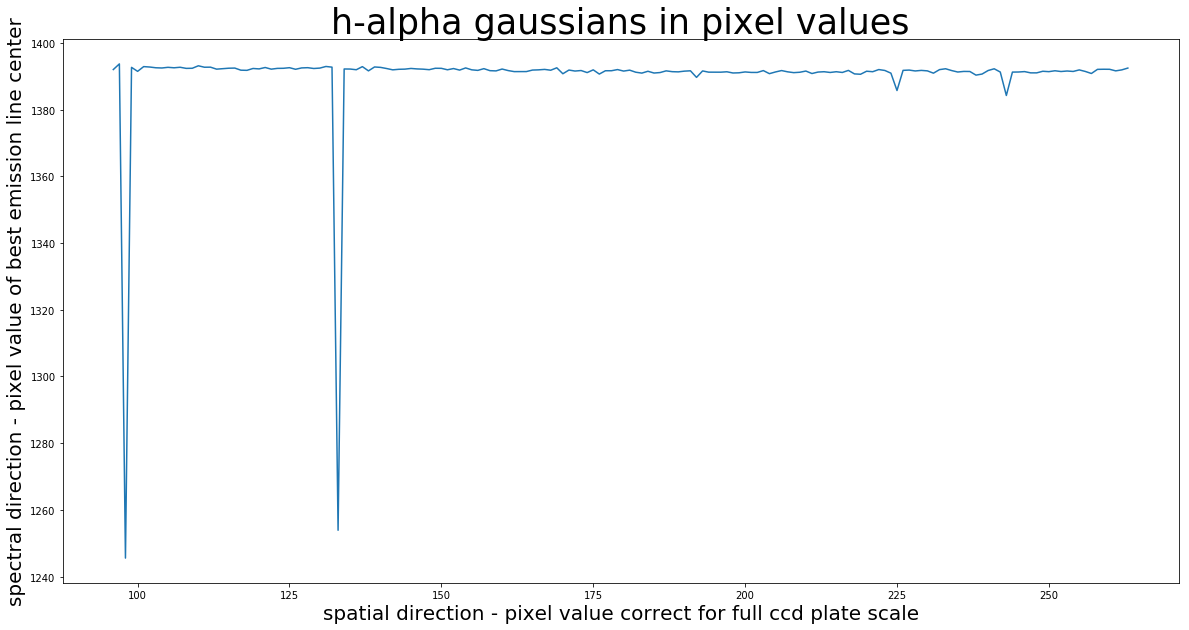

In [16]:
#gaussian means
plt.figure(figsize=(20,10))
plt.xlabel("spatial direction - pixel value correct for full ccd plate scale",fontsize=20)
plt.ylabel('spectral direction - pixel value of best emission line center',fontsize=20)
plt.plot(target_spacepix_fullccd,gaussmeans_specpix_fullccd)#(spaital pix index,corrected "wl" of centroid values (still in pix space))
plt.title('h-alpha gaussians in pixel values',fontsize=35)

(1390, 1394)

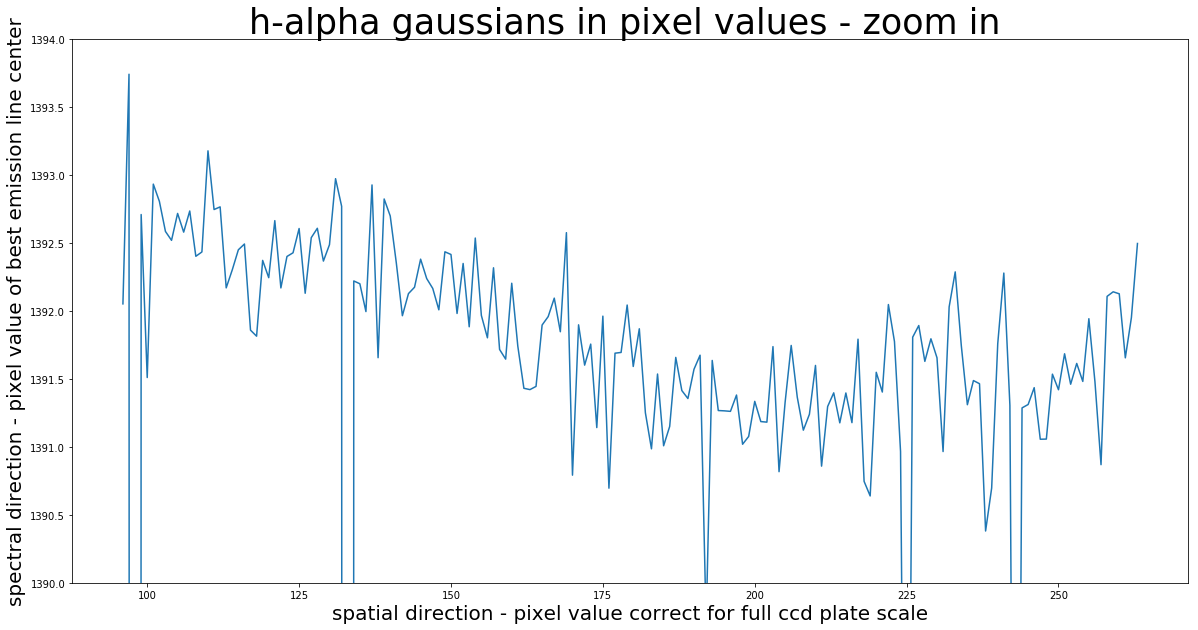

In [17]:
#zooming in 
plt.figure(figsize=(20,10))
plt.xlabel("spatial direction - pixel value correct for full ccd plate scale",fontsize=20)
plt.ylabel('spectral direction - pixel value of best emission line center',fontsize=20)
plt.plot(target_spacepix_fullccd,gaussmeans_specpix_fullccd)#(spaital pix index,corrected "wl" of centroid values (still in pix space))
plt.title('h-alpha gaussians in pixel values - zoom in ',fontsize=35)
plt.ylim(1390,1394)


# removes bad fits

In [18]:
#collecting indicies of bad matrices


matrix = np.arange(0,len(means_unc),1)
print('these should be the same, if not explore:',len(matrix),len(gaussian_means))

badindices = []
for i in matrix:
    #print()
    if np.any(means_unc[i]) == None:
        print('bad matrix at array:',i, means_unc[i])
        badindices.append(i)
    else:
        ok = 'ok'
        #print(ok)
        #print(means_unc[i])
print('number of bad fits is:',len(badindices))

these should be the same, if not explore: 168 168
bad matrix at array: 2 None
bad matrix at array: 37 None
number of bad fits is: 2


In [19]:
#masking bad uncertaiinty values


evenmore_badindices=[]
masked_gsigs_means=[]
for i in  range(len(means_unc)):
    #print(type(means_unc[i]))
    #if type(means_unc[i][1][1]) != np.ndarray:
    if type(means_unc[i]) == np.ndarray: #'NoneType':
        gmatrix_unc=means_unc[i][1][1]
        #print(i)
    #b/c these are the good fits, keep those vals
    else:
        gmatrix_unc=np.nan
        evenmore_bad = i
        evenmore_badindices.append(evenmore_bad)
        #print(i)
    #print(i, gmatrix_unc)
    masked_gsigs_means.append(gmatrix_unc)
evenmore_badindices = np.array(evenmore_badindices)
masked_gsigs_means = np.array(masked_gsigs_means)
#print(masked_gsigs_means)
print(evenmore_badindices,len(evenmore_badindices),badindices,'good they match, as they should')

[ 2 37] 2 [2, 37] good they match, as they should


In [20]:
#masking bad gaussian values


more2_badindices=[]
more_badindices=[]
masked_gaussian_means=[]
for i in  range(len(gaussian_means)):
    #b/c bad fit produced no cov matrix
    if i in badindices:
        gaussian_means[i] = np.nan
    #b/c mean value shouldnt be outside this pixel range
    elif gaussian_means[i] <=0.0:
        gaussian_means[i]=np.nan
        more2_bads = i
        more2_badindices.append(more2_bads)
###############depends on width of h-alpha######################################
    elif gaussian_means[i] >=9.0:
###############################################################################
        gaussian_means[i] = np.nan
        more2_bads=i
        more2_badindices.append(more2_bads)
    #b/c these are the good fits, keep those vals
    else:
        gaussian_means[i]=gaussian_means[i]
    #print(i,gaussian_means[i])
    masked_gaussian_means.append(gaussian_means[i])
#more_badindices = np.array(more_badindices)
more2_badindices = np.array(more2_badindices)
masked_gaussian_means = np.array(masked_gaussian_means)

In [21]:
#collecting all bad fit indicies.....NOT in fullccd pix space, in target pix space


all_bad_idx = np.concatenate([more2_badindices,evenmore_badindices])
all_bad_idxs = np.sort(all_bad_idx)
all_bad_idxs
#more2_badindices, evenmore_badindices

array([  2,  37, 129, 147])

In [22]:
# changing those (evenmore bad indicies) values to nan in the uncertainity array


fullmask_sigma=[]
for i in  range(len(masked_gsigs_means)):
    #b/c bad fit produced no cov matrix
    if i in more2_badindices:
        masked_gsigs_means[i] = np.nan
    #b/c these are the good fits, keep those vals
    else:
        masked_gsigs_means[i]=masked_gsigs_means[i]
    #print(i,masked_gsigs_means[i])
    fullmask_sigma.append(masked_gsigs_means[i])
fullmask_sigma = np.array(fullmask_sigma)

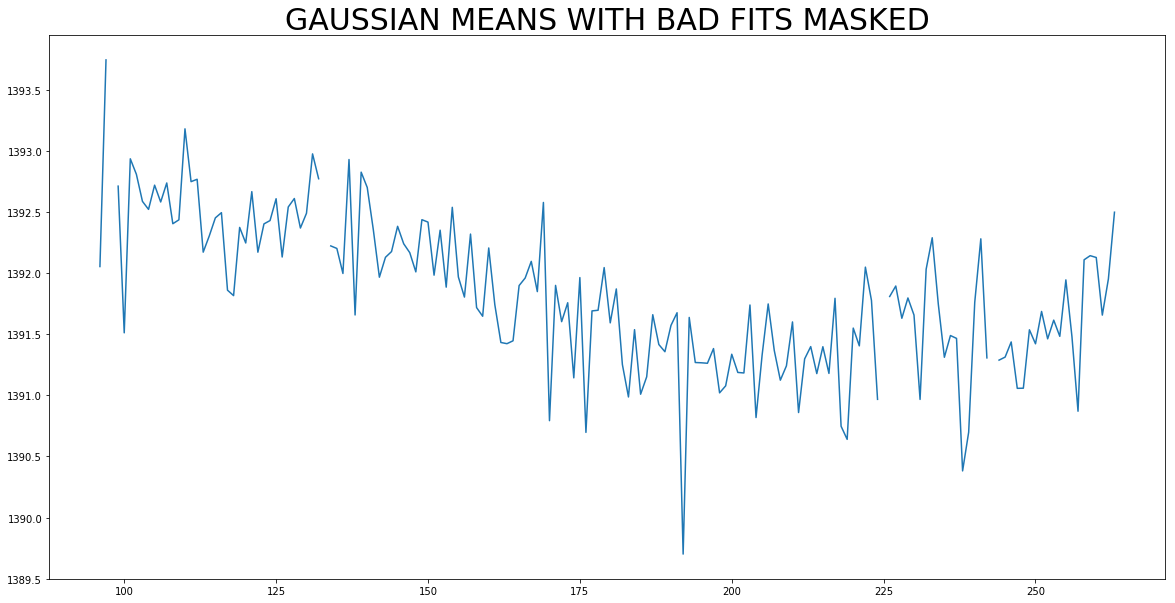

In [23]:
gaussmeans_specpix_fullccd_MASKED = masked_gaussian_means + wl_pix_correction + bestline_range_correction[0]
gaussmax_specpix_fullccd_MASKED = masked_gaussian_means + stddev + wl_pix_correction + bestline_range_correction[0]


plt.figure(figsize=(20,10))
plt.title('GAUSSIAN MEANS WITH BAD FITS MASKED',fontsize=30)
plt.plot(target_spacepix_fullccd,gaussmeans_specpix_fullccd_MASKED)

(1390, 1397)

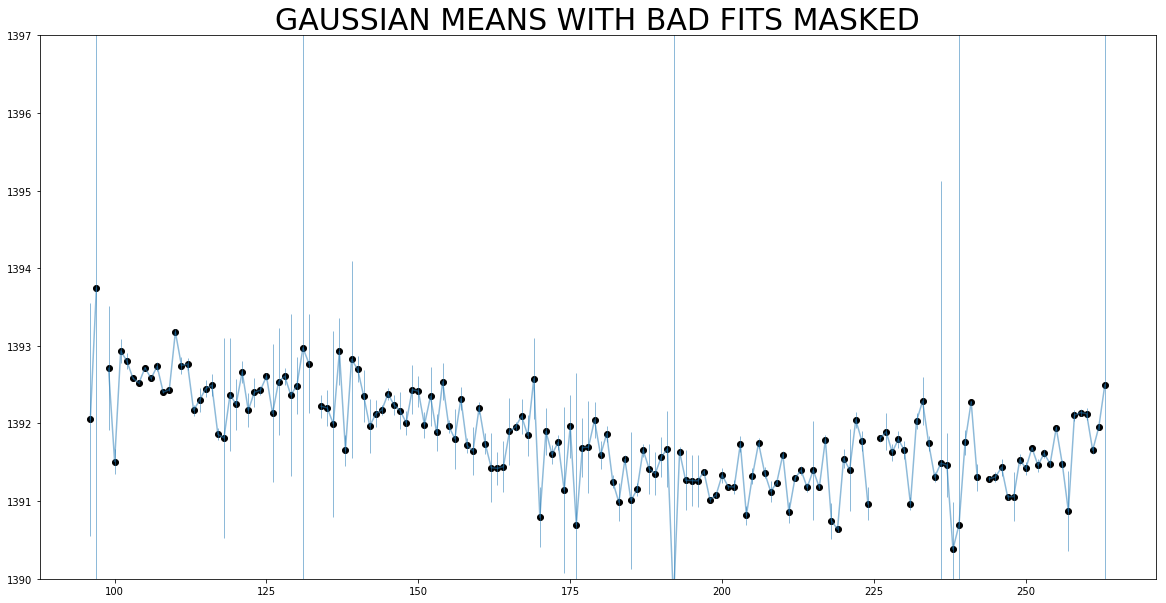

In [24]:
#with error bars


plt.figure(figsize=(20,10))
plt.title('GAUSSIAN MEANS WITH BAD FITS MASKED',fontsize=30)
plt.scatter(target_spacepix_fullccd,gaussmeans_specpix_fullccd_MASKED,marker='o',c='k')
plt.errorbar(target_spacepix_fullccd,gaussmeans_specpix_fullccd_MASKED,yerr=fullmask_sigma,capsize=0,elinewidth=1,alpha=.5)

plt.ylim(1390,1397)

In [25]:
print(gaussmeans_specpix_fullccd_MASKED)

[1392.05244554 1393.74225574           nan 1392.70984775 1391.51039044
 1392.93353998 1392.8069569  1392.58539064 1392.51998431 1392.71792104
 1392.58042865 1392.73586011 1392.40258126 1392.43448823 1393.17856483
 1392.74664741 1392.76613843 1392.17017314 1392.30297502 1392.45036717
 1392.49288531 1391.85901625 1391.81469074 1392.37232836 1392.2451628
 1392.66488303 1392.16973969 1392.40115108 1392.42840291 1392.60696201
 1392.13049743 1392.53955588 1392.60865254 1392.3673671  1392.48806078
 1392.97370865 1392.77063756           nan 1392.22112392 1392.2003997
 1391.99575556 1392.92760181 1391.65641093 1392.82424926 1392.6993391
 1392.35410447 1391.96530135 1392.1278725  1392.17491224 1392.38139471
 1392.23891418 1392.16593004 1392.00873155 1392.43560632 1392.41586766
 1391.98192534 1392.34970872 1391.8839297  1392.53677363 1391.96732802
 1391.80278093 1392.31791097 1391.7168451  1391.64589281 1392.20429359
 1391.74101107 1391.43127123 1391.42160093 1391.44521371 1391.89684094
 1391.958

# apply ds

Text(0.5,1,'h-alpha gaussian means in wl values')

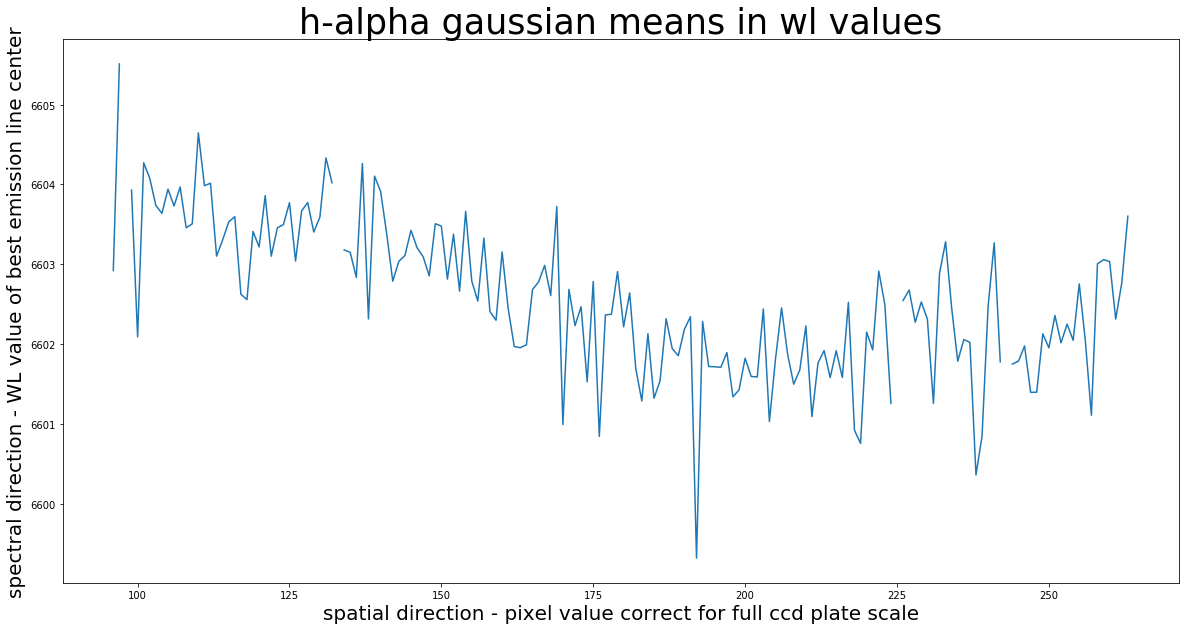

In [26]:
#applies ds


#gotta figure a way to keep masked values masked and not just add to a val from corrections
################################################################
wl_gaussians = np.array(ds_red.pixtowl(gaussmeans_specpix_fullccd_MASKED))
#################################################################

#plotting
plt.figure(figsize=(20,10))
plt.xlabel("spatial direction - pixel value correct for full ccd plate scale",fontsize=20)
plt.ylabel('spectral direction - WL value of best emission line center',fontsize=20)
plt.plot(target_spacepix_fullccd,wl_gaussians)#(spaital pix index,corrected "wl" of centroid values (still in pix space))
##########################################################
plt.title('h-alpha gaussian means in wl values',fontsize=35)
#plt.axvline(165)

# getting galaxy spectral core pix

In [27]:
#NOTE THAT THIS CELL USES GAUSSIAN VALUES.....IF CENTROIDS HAVE BETTER FIT (less likely) CHANGE IT

#robust way to clean data (to avoid bad g fits)
#################################################################
cleaned_gaussmeans = sigma_clip(masked_gaussian_means, sigma=3)
################################################################
avg_of_gmeans = np.mean(cleaned_gaussmeans)

#correcting avg Ha wl pixel value to reflect its place on the full ccd scale
bestline_corewl_pix_fullccd = avg_of_gmeans + wl_pix_correction + bestline_range_correction[0]
print('pix value of halpha core spectral axis is:',bestline_corewl_pix_fullccd)

#applying ds to get pix to wl value
########################################################################
bestline_core_wl = ds_red.pixtowl(bestline_corewl_pix_fullccd)*u.angstrom
#########################################################################

print('Best emission line "core" wl (based on gaussian fits) is:',bestline_core_wl)

pix value of halpha core spectral axis is: 1391.8204325057889
Best emission line "core" wl (based on gaussian fits) is: 6602.565633435681 Angstrom


In [28]:
wl_gauss_test = ds_red.pixtowl(gaussmeans_specpix_fullccd_MASKED)*u.angstrom
wl_gaussians = np.array(ds_red.pixtowl(gaussmeans_specpix_fullccd_MASKED))
average = np.nanmean(wl_gauss_test)
#print(wl_gauss_test,'thank you next',wl_gaussians,'average of the averaged',average)
print(average)




6602.563788752304 Angstrom


# getting galaxy spatial core

(168, 4104)
1387 1378
shape of first section: (168, 10) matches shape of second section: (168, 10)
shape of first section 2d: (168, 1)
shape of second section 2d: (168, 1)
first section centroid y,x: 0.0 65.9133808788043
second section centroid y,x: 0.0 69.65585059412356
This is the average pixel value of the core BEFORE SPATIAL CORRECTIONS 67.78461573646393
Pixel Value of core along spatial axis wrt full CCD size 163.78461573646393


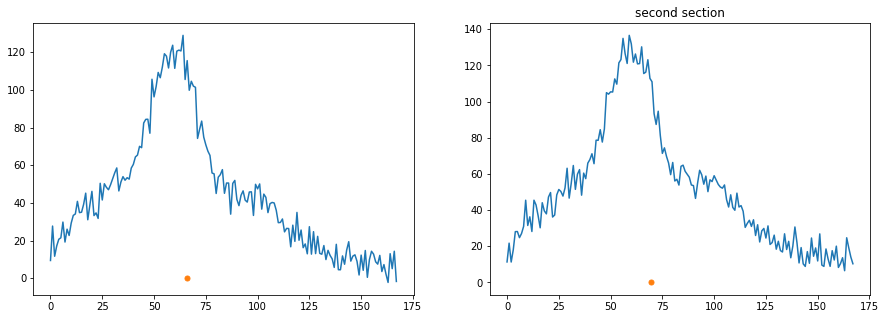

In [29]:
#USING SECTIONS SURROUNDING HALPHA WL RANGE
print(np.shape(flux_data))#(168,4104) #note that this is missing those wl's


#making arrays surrounding best emission line
################################################
upperha = bestline_range_correction[1]
lowerha = bestline_range_correction[0]
print(bestline_range_correction[1],bestline_range_correction[0])
#################################################
width_sections = 10 #reduced from 50 to 25 to avoid cosmic rays skewing to higher pix side
upper_one = lowerha - 1 #distance to avoid line emission contaminating core determination
lower_one = upper_one - width_sections
lower_two = upperha + 1 #giving it some distance
upper_two = lower_two + width_sections
first_section = flux_data[:,lower_one:upper_one]
second_section = flux_data[:,lower_two:upper_two]
print('shape of first section:', np.shape(first_section), 'matches shape of second section:', np.shape(second_section))


#collapsing both sections in the spatial direction (histogram like)
first_section_sum = np.sum(first_section,axis=1) 
first_section2d = first_section_sum[:,np.newaxis] #2d required to centroid
second_section_sum = np.sum(second_section,axis=1)
second_section2d = second_section_sum[:,np.newaxis] #2d required to centroid
print('shape of first section 2d:', np.shape(first_section2d))
print('shape of second section 2d:', np.shape(second_section2d))


#does the centroiding
y_first, x_first = centroid_com(first_section2d)
y_second, x_second = centroid_com(second_section2d)
print('first section centroid y,x:',x_first,y_first)
print('second section centroid y,x:',x_second,y_second)



#verify by plots
f, (ax1,ax2) = plt.subplots(1,2,figsize=(15,5))
ax1.plot(first_section2d);
ax2.plot(second_section2d);
#note below had to reverse xy centroids to visualize correctly, not sure why it inverted tho...
ax1.plot(y_first,x_first, '.', markersize=10)
ax2.plot(y_second,x_second, '.', markersize=10)
ax2.set_title('second section')
#averaging the two core values, the y's
core_array = np.array([y_first,y_second])
core_avgcentroids = np.mean(core_array)
print('This is the average pixel value of the core BEFORE SPATIAL CORRECTIONS',core_avgcentroids)

#FULL CCD pixel value of core
core_from_sections = core_avgcentroids + space_pix_correction #corrects for spatial axis target cutout
print('Pixel Value of core along spatial axis wrt full CCD size',core_from_sections)

# converting pix -------> kpc

In [30]:
distance_pix_wrtcore_sections = target_spacepix_fullccd - core_from_sections #for core wl using 2 sections around best emission line

In [31]:
#actual converting for loop CENTROIDS pixels to kpc
## good for core defined by 2 sections around halpha

#converts pixels to kpc (distance profile)
arcmins_sections =[]
distances_sections=[]
more_sections = []


#converts pix to kpc and saves as quantity list
for i in distance_pix_wrtcore_sections:
    r_in_arcmin = 1*u.arcmin
    redplatescale = 0.293*u.arcsec/u.pixel
    blueplatescale = 0.389*u.arcsec/u.pixel
    dbsp_pix_equiv_red = u.pixel_scale(redplatescale)
    dbsp_pix_equiv_blue = u.pixel_scale(blueplatescale)
    r_in_pixel = i*u.pixel
    ################################################################
    r_in_arcmin = r_in_pixel.to('arcmin', dbsp_pix_equiv_red)
    distance = 28*u.Mpc # distance of object (host) from us
#####note for G-1, google sheet has G dist =27.7Mpc but SAGA1 paper =28Mpc
    ###############################################################
    rad_to_arcmin = (1*u.rad).to('arcmin')
    r_in_kpc = ((r_in_arcmin/rad_to_arcmin)*distance).to("kpc") #gets radians*distancefromus for gal width in kpc
    more_sections = r_in_kpc #/ (1*u.kpc)
    distances_sections.append(more_sections.value)
distances_sections = np.array(distances_sections)

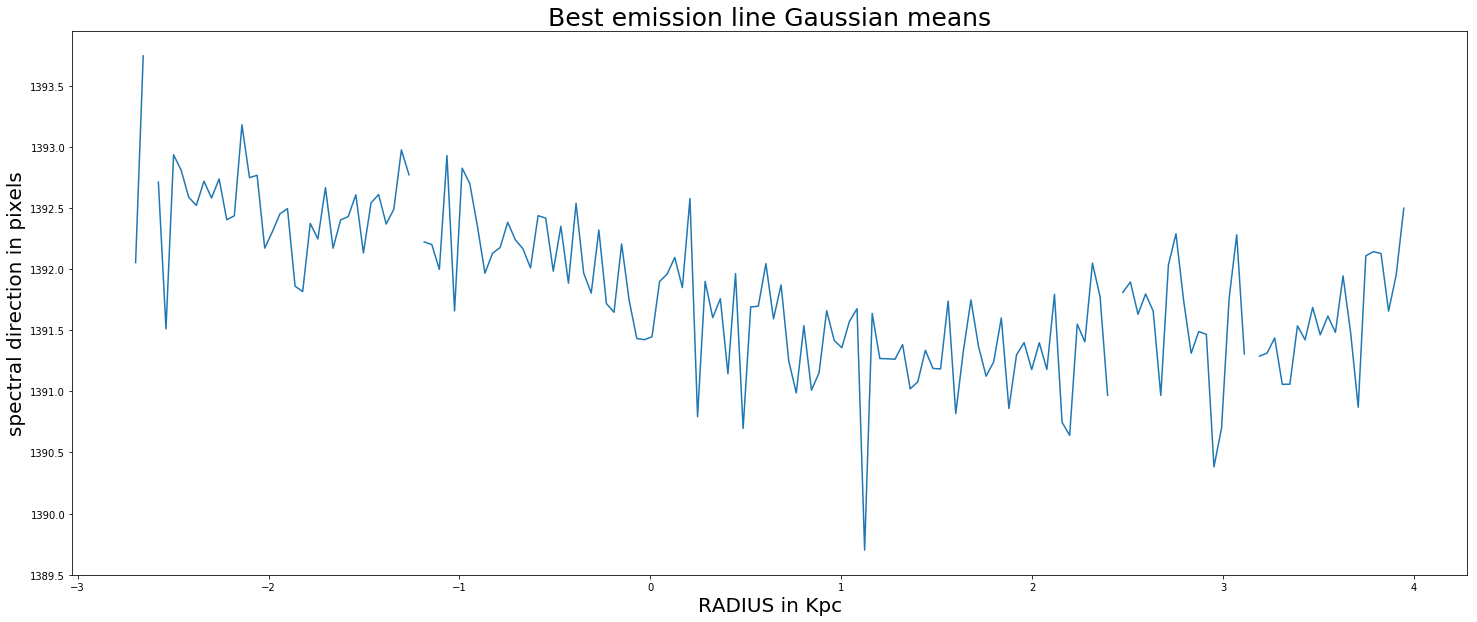

In [32]:
#GAUSSIAN MEANS plot with pix-wls & kpc

plt.figure(figsize=(25,10))
plt.title('Best emission line Gaussian means', SIZE=25)
plt.xlabel('RADIUS in Kpc',fontsize=20)
plt.ylabel('spectral direction in pixels',fontsize=20)
plt.plot(distances_sections * u.kpc, gaussmeans_specpix_fullccd_MASKED)

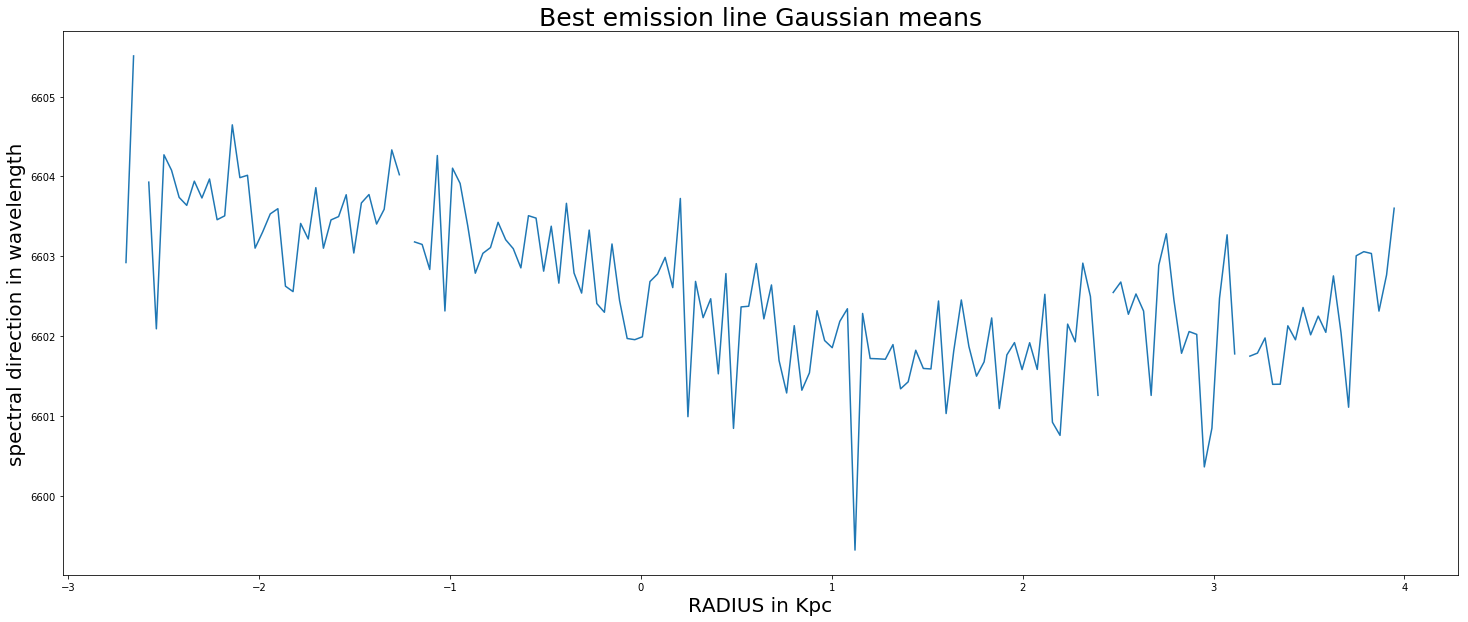

In [33]:
#GAUSSIAN MEANS plot with wl & kpc

plt.figure(figsize=(25,10))
plt.title('Best emission line Gaussian means', SIZE=25)
plt.xlabel('RADIUS in Kpc',fontsize=20)
plt.ylabel('spectral direction in wavelength',fontsize=20)
plt.plot(distances_sections * u.kpc, wl_gaussians)

# these dont rely on finding spatial core

In [34]:
### doesnt rely on distance from core



distances_sections_target=[]
more_sections_target = []

#converts pix to kpc and saves as quantity list
for i in target_spacepix_fullccd:
    r_in_arcmin = 1*u.arcmin
    redplatescale = 0.293*u.arcsec/u.pixel
    blueplatescale = 0.389*u.arcsec/u.pixel
    dbsp_pix_equiv_red = u.pixel_scale(redplatescale)
    dbsp_pix_equiv_blue = u.pixel_scale(blueplatescale)
    r_in_pixel = i*u.pixel
    ################################################################
    r_in_arcmin = r_in_pixel.to('arcmin', dbsp_pix_equiv_red)
    distance = 28*u.Mpc # distance of object (host) from us
#####note for G-1, google sheet has G dist =27.7Mpc but SAGA1 paper =28Mpc
    ###############################################################
    rad_to_arcmin = (1*u.rad).to('arcmin')
    r_in_kpc = ((r_in_arcmin/rad_to_arcmin)*distance).to("kpc") #gets radians*distancefromus for gal width in kpc
    more_sections_target = r_in_kpc #/ (1*u.kpc)
    distances_sections_target.append(more_sections_target.value)
distances_sections_target = np.array(distances_sections_target)

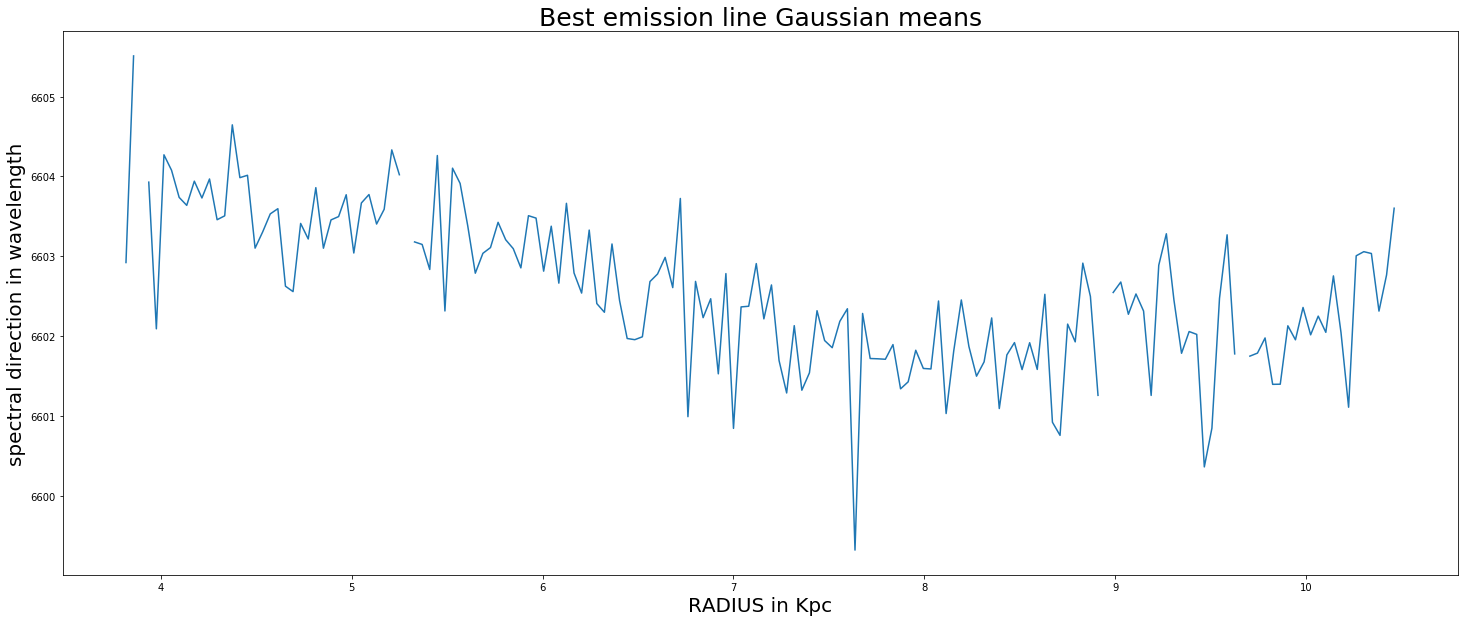

In [35]:
#GAUSSIAN MEANS plot with wl & kpc.....NO SPATIAL CORE from sections used

plt.figure(figsize=(25,10))
plt.title('Best emission line Gaussian means', SIZE=25)
plt.xlabel('RADIUS in Kpc',fontsize=20)
plt.ylabel('spectral direction in wavelength',fontsize=20)
plt.plot(distances_sections_target * u.kpc, wl_gaussians)

# converting pix---->wl -----> velocity

In [36]:
#convert pix to wl via ds
###################################################################
#centroids_wl = ds_red10.pixtowl(centroid_specpix_fullccd)*u.angstrom
gauss_meanWstd_wl  = ds_red.pixtowl(gaussmax_specpix_fullccd_MASKED)*u.angstrom
gauss_means_wl = ds_red.pixtowl(gaussmeans_specpix_fullccd_MASKED)*u.angstrom
#core_wl_sections = ds_red.pixtowl(core_from_sections)*u.angstrom
####################################################################

In [37]:
#using redshift formula to get velocity

#((obs_wl - true_wl)/true_wl)* c = velocity
#except what we want is  v_not relative to core - v_of core

#velocities NOT yet relative to the core
##############################################################################
v_spec_gaussians = ((gauss_means_wl/(6563*u.angstrom)) -1) * const.c #gaussian velocities
#v_spec_centroids = (centroids_wl /(6563*u.angstrom) -1) * const.c #centroid velocities
#v_core = ((bestline_core_wl/(6563*u.angstrom)) -1) * const.c #core velocity
v_core = ((average/(6563*u.angstrom)) -1) * const.c #core velocity
#v_core uses average val of gaussmeans_specpix_fullccd_MASKED passed into ds(so more like normalizing)
#average = np.nanmean(gauss_means_wl)
###############################################################################

#velocities relative to the core from sections
y_axis_Gvelocity = (v_spec_gaussians - v_core).to('km/s')  #gaussian
#y_axis_Cvelocity = (v_spec_centroids - v_core).to('km/s') #centroids

print("velocity of best emission line's spectral 'core':",v_core.to('km/s'), len(y_axis_Gvelocity),y_axis_Gvelocity)

velocity of best emission line's spectral 'core': 1807.241425848845 km / s 168 [  16.3307014   134.65908858           nan   62.3647694   -21.62599049
   78.02872676   69.16479252   53.64972957   49.06969362   62.93009721
   53.30226908   64.18627177   40.84862957   43.08289095   95.18654333
   64.94164739   66.3064968    24.5744552    33.87378457   44.19480191
   47.1721041     2.78604144   -0.31779616   38.73019395   29.8255351
   59.21613824   24.54410295   40.74848212   42.6567709    55.1602518
   21.79620292   50.44017955   55.27863026   38.38278558   46.83426976
   80.84152664   66.62154702           nan   28.14223434   26.69104073
   12.36104788   77.61290847  -11.40112368   70.37568306   61.62890668
   37.45408119   10.22852675   21.61239471   24.90630601   39.36505809
   29.38798082   24.27733628   13.26967726   43.16118469   41.77899955
   11.39260308   37.14627246    4.53057452   50.24535446   10.3704424
   -1.15176527   34.91966105   -7.16930597  -12.1376403    26.96370648
 

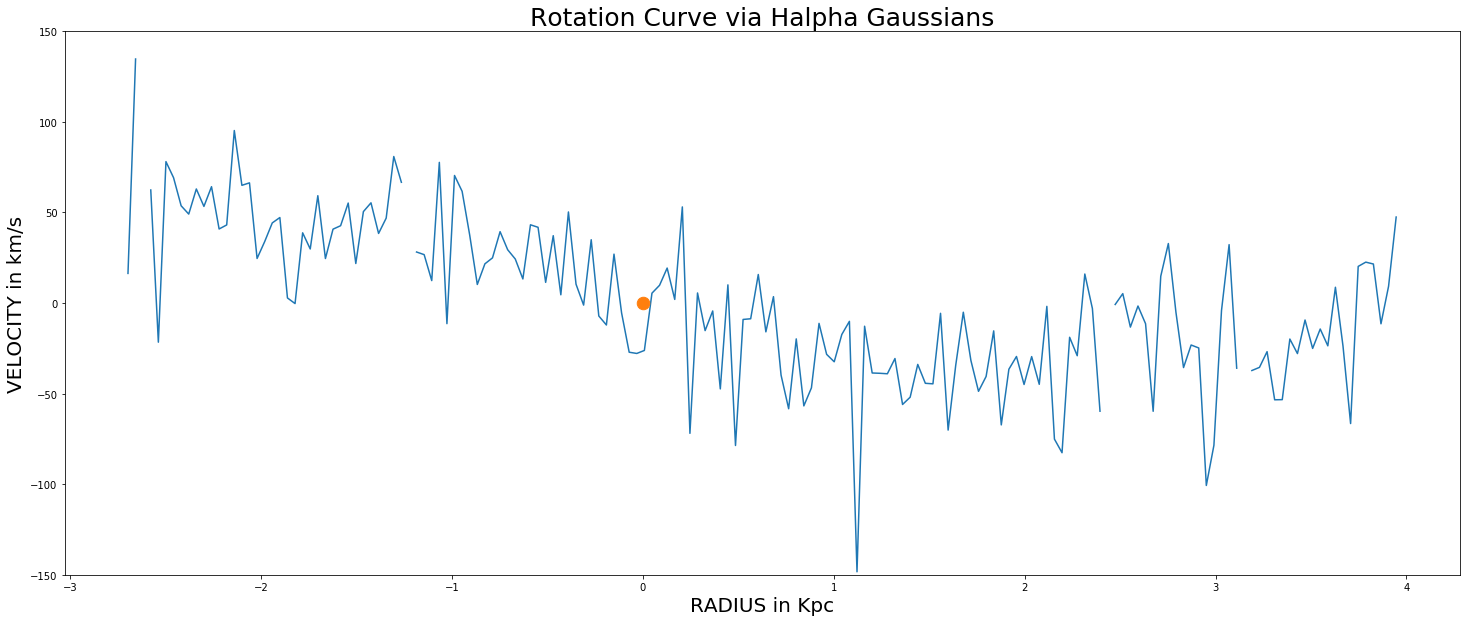

In [38]:
# used core from sections

plt.figure(figsize=(25,10))
#######################################################
plt.title('Rotation Curve via Halpha Gaussians', SIZE=25)
#######################################################
plt.xlabel('RADIUS in Kpc',fontsize=20)
plt.ylabel('VELOCITY in km/s',fontsize=20)
plt.plot(distances_sections * u.kpc, y_axis_Gvelocity)
plt.ylim(-150,150) #adjust as needed to center around zero
plt.plot(0,0,'.', markersize=25)

# error bars

In [39]:
#newer way trying to get core from eriks model

########################################### fullmask_sigma is in pixels
sigma_gauss_pix = np.sqrt(np.abs(fullmask_sigma)) #taking sqrt of unc to get a true sigma
################################################
#correct to full ccd pix scale
#print(sigma_gauss_pix)
means_Wsigma_fullccd = masked_gaussian_means + sigma_gauss_pix + wl_pix_correction + bestline_range_correction[0]
#apply ds
means_max_wl = ds_red.pixtowl(means_Wsigma_fullccd)*u.angstrom


#making into velocities
v_means_withsigma = (means_max_wl/ (6563*u.angstrom)-1) * const.c #be sure to check all values ok (no inf)
#in converting pix2wl2vel section...already did same steps for means w/o sigma


#extracting sigma velocity
v_unc = (v_means_withsigma - v_spec_gaussians).to('km/s') 
#print(np.shape(v_unc))
#np.reshape(v_unc,(226,))
print('v_unc', np.shape(v_unc))#make sure its same length as y_axis_Gvelocitys_unc

v_unc (168,)


In [40]:
dist_kpc = distances_sections * u.kpc

(-150, 150)

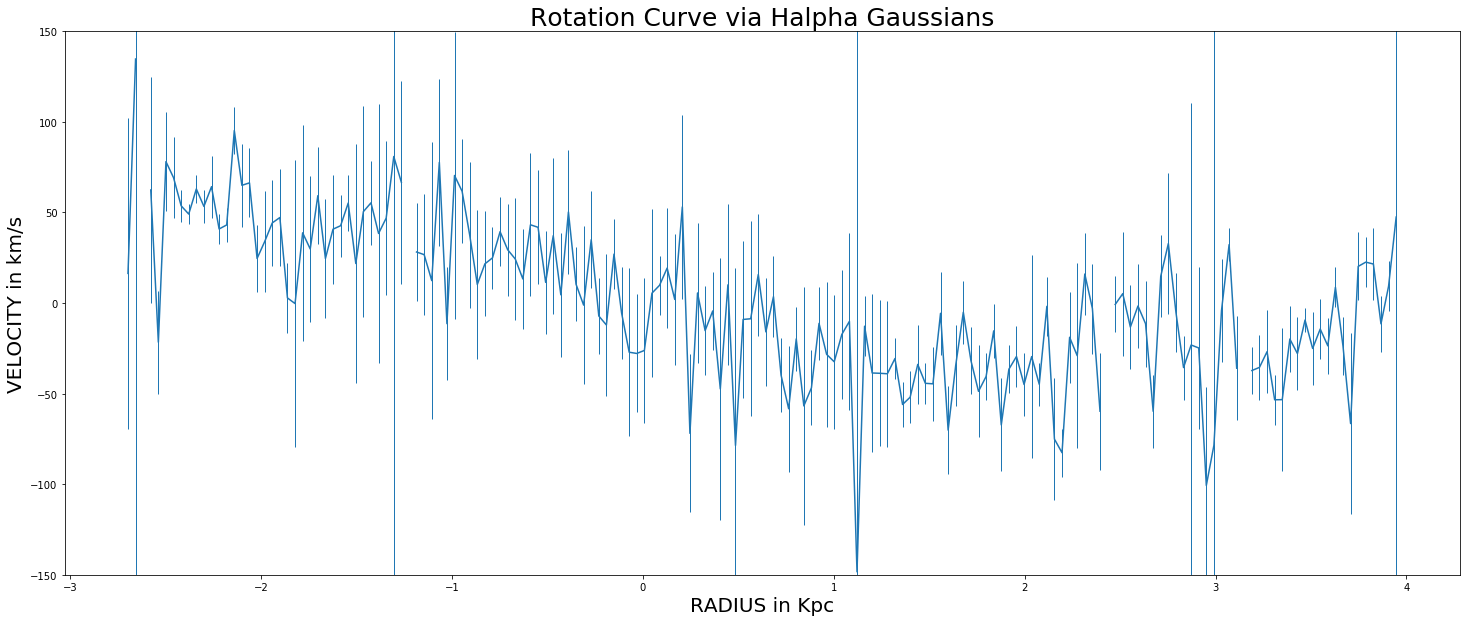

In [41]:
plt.figure(figsize=(25,10))
#######################################################
plt.title('Rotation Curve via Halpha Gaussians', SIZE=25)
#######################################################
plt.xlabel('RADIUS in Kpc',fontsize=20)
plt.ylabel('VELOCITY in km/s',fontsize=20)
plt.errorbar(np.asarray(dist_kpc), np.asarray(y_axis_Gvelocity),yerr=np.asarray(v_unc),elinewidth=1)
plt.ylim(-150,150) #adjust as needed to center around zero
#plt.plot(0,0,'.', markersize=25)

(-250, 250)

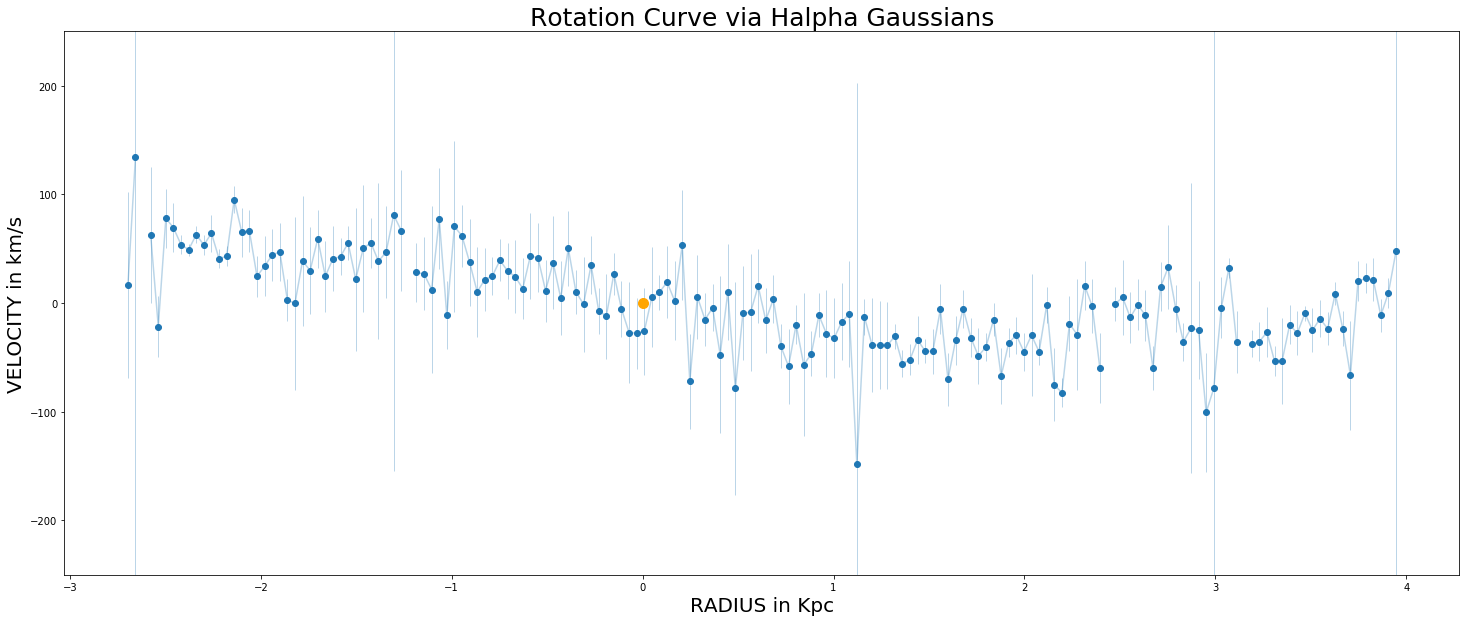

In [42]:
plt.figure(figsize=(25,10))
#######################################################
plt.title('Rotation Curve via Halpha Gaussians', SIZE=25)
#######################################################
plt.xlabel('RADIUS in Kpc',fontsize=20)
plt.ylabel('VELOCITY in km/s',fontsize=20)
plt.scatter(distances_sections * u.kpc, y_axis_Gvelocity)
plt.plot(0,0,'.', markersize=20,color='orange')
plt.errorbar(np.asarray(distances_sections * u.kpc), np.asarray(y_axis_Gvelocity),yerr=np.asarray(v_unc),elinewidth=1,alpha=0.3)
plt.ylim(-250,250) #adjust as needed to center around zero
#plt.plot(0,0,'.', markersize=25)

# mass modeling

In [43]:
arr=np.asarray



Model: eriksmodel
Inputs: ('r',)
Outputs: ('r',)
Model set size: 1
Parameters:
    r_cen       alpha              beta              sigma              omega      
    ----- ----------------- ------------------ ------------------ -----------------
      0.0 15.25968906096989 29.478165145376277 -250.8004960028402 1.061186239377167


Text(0.5,1,'first attempt - uses defaults')

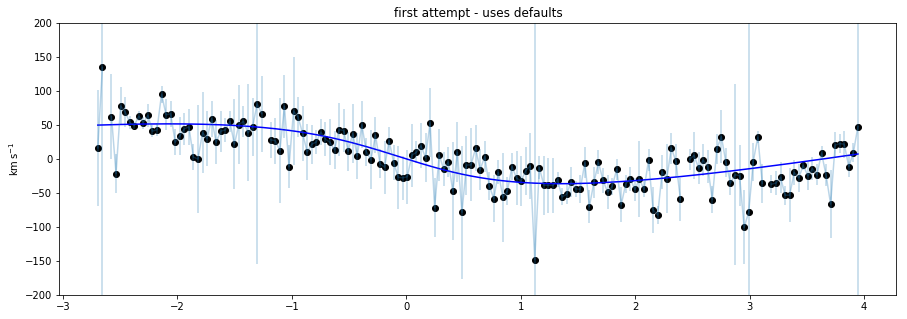

In [44]:
#uses core from sections
#eriks model eqt 5



@models.custom_model #very necessary line
def eriksmodel(r, r_cen=0, alpha=.00001, beta=.00001, sigma=50, omega=.3):
    return (r * ((alpha + beta)/2) + (sigma - r*(alpha - beta)) * (np.arctan(r / omega))/np.pi)



#fit model to data
m_init = eriksmodel()
fit = fitting.LevMarLSQFitter()
nan_msk = ~np.isnan(v_unc)
m = fit(m_init, arr(distances_sections)[nan_msk], arr(y_axis_Gvelocity.value)[nan_msk],weights=arr(1/(v_unc.value[nan_msk])**2))

print(m)

#plot data & fit
plt.figure(figsize=(15,5))
########################################################################
plt.scatter(distances_sections,y_axis_Gvelocity, color='k')
plt.errorbar(distances_sections, y_axis_Gvelocity, yerr=v_unc,alpha=.3)
########################################################################
plt.plot(distances_sections, m(distances_sections), color='b')
plt.ylim(-200,200) #zooms to see data good, if fit is good
plt.title('first attempt - uses defaults')

/Users/dee/miniconda3/lib/python3.6/site-packages/ipykernel_launcher.py:8: RuntimeWarning: divide by zero encountered in true_divide
  


Model: eriksmodel
Inputs: ('r',)
Outputs: ('r',)
Model set size: 1
Parameters:
    r_cen alpha beta       sigma               omega       
    ----- ----- ---- ------------------ -------------------
      0.0 1e-05  1.0 -75.13012778720986 0.08285409964027426


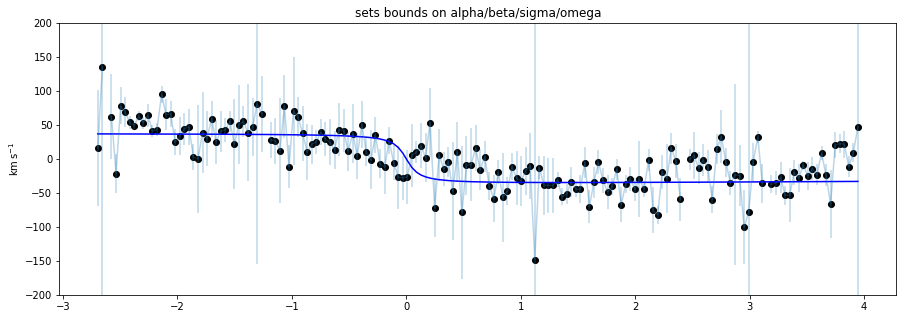

In [45]:
#uses core from sections & sets bounds
#eriks model eqt 5



@models.custom_model #very necessary line
def eriksmodel(r, r_cen=0, alpha=.01, beta=.00001, sigma=-120, omega=1):
    return (r * ((alpha + beta)/2) + (sigma - r*(alpha - beta)) * (np.arctan(r / omega))/np.pi)



#fit model to data
#m_init = eriksmodel()
m_init = eriksmodel(bounds={'alpha':(0.00001,1), 'beta':(0.00001,1),'sigma': (-300,300),'omega':(0,100)})

fit = fitting.LevMarLSQFitter()
nan_msk = ~np.isnan(v_unc)
m = fit(m_init, arr(distances_sections)[nan_msk], arr(y_axis_Gvelocity.value)[nan_msk],weights=arr(1/(v_unc.value[nan_msk])**2))

print(m)

#plot data & fit
plt.figure(figsize=(15,5))
########################################################################
plt.scatter(distances_sections,y_axis_Gvelocity, color='k')
plt.errorbar(distances_sections, y_axis_Gvelocity, yerr=v_unc,alpha=.3)
########################################################################
plt.plot(distances_sections, m(distances_sections), color='b')
plt.ylim(-200,200) #zooms to see data good, if fit is good
plt.title('sets bounds on alpha/beta/sigma/omega');

<eriksmodel(alpha=11.73636892, beta=28.56198639, sigma=-233.84608754, omega=1.02593768, v_offset=-2.29311372)>


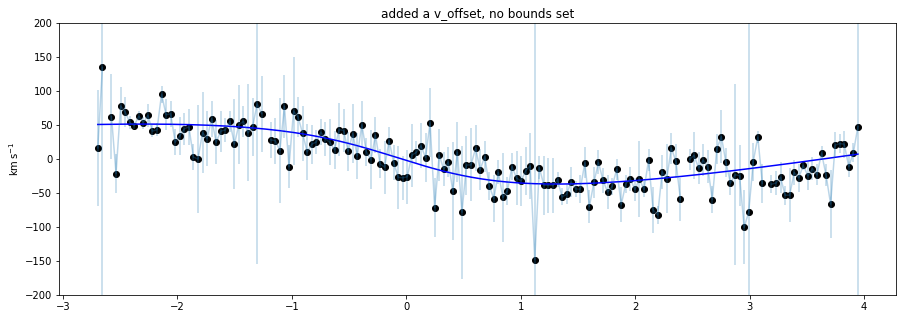

In [46]:
# added in a v-offset 

#uses core from sections
#eriks model eqt 5



@models.custom_model #very necessary line
def eriksmodel(r, alpha=.00001, beta=.00001, sigma=50, omega=.3,v_offset=0):
    return (r * ((alpha + beta)/2) + (sigma - r*(alpha - beta)) * (np.arctan(r / omega))/np.pi)+v_offset


#fit model to data
m_init = eriksmodel()
fit = fitting.LevMarLSQFitter()
nan_msk = ~np.isnan(v_unc)
m = fit(m_init, arr(distances_sections)[nan_msk], arr(y_axis_Gvelocity.value)[nan_msk],weights=arr(1/(v_unc.value[nan_msk])**2))

print(repr(m))

#plot data & fit
plt.figure(figsize=(15,5))
########################################################################
plt.scatter(distances_sections,y_axis_Gvelocity, color='k')
plt.errorbar(distances_sections, y_axis_Gvelocity, yerr=v_unc,alpha=.3)
########################################################################
plt.plot(distances_sections, m(distances_sections), color='b')
plt.ylim(-200,200) #zooms to see data good, if fit is good
plt.title('added a v_offset, no bounds set');
#print('WHY ARE ALPHA & BETA SOOOOOOO HIGH, LOOKS POLY LIKE ----FITS GET WORSE IF FORCE THEM TO BE LOW ')

/Users/dee/miniconda3/lib/python3.6/site-packages/ipykernel_launcher.py:11: RuntimeWarning: divide by zero encountered in true_divide
  # This is added back by InteractiveShellApp.init_path()


Model: eriksmodel
Inputs: ('r',)
Outputs: ('r',)
Model set size: 1
Parameters:
    r_cen alpha beta       sigma              omega            v_offset    
    ----- ----- ---- ------------------ ------------------ ----------------
      5.0  0.01  1.0 -91.76526876491835 0.5755440434138622 23.8025095891807


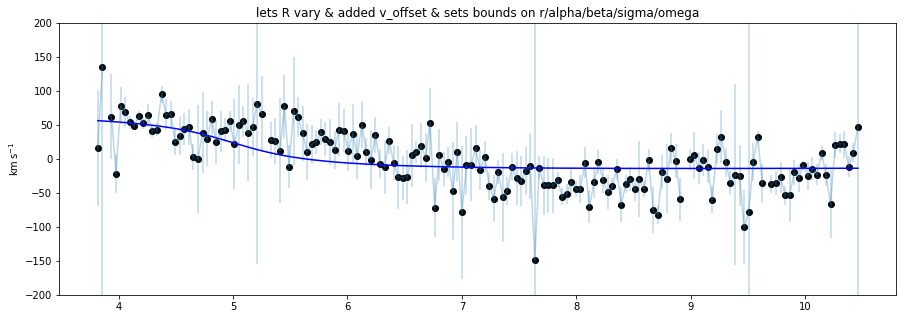

In [47]:
# added in a v-offset & dr b/c v-offset & BOUNDS ON ALPHA/BETA

#uses core from sections
#eriks model eqt 5



@models.custom_model #very necessary line
def eriksmodel(r,r_cen=0, alpha=.1, beta=.8, sigma=-200, omega=10,v_offset=0):
    dr = r-r_cen
    return (dr * ((alpha + beta)/2) + (sigma - dr*(alpha - beta)) * (np.arctan(dr / omega))/np.pi)+v_offset

# setting bounds
m_init = eriksmodel(bounds={'r_cen': (5,9), 'alpha':(.01,1), 'beta':(.01,1),'sigma': (-300,300),'omega':(0,100)})
m_init.r_cen=7

#fit model to data
fit = fitting.LevMarLSQFitter()
nan_msk = ~np.isnan(v_unc)
m = fit(m_init, arr(distances_sections_target)[nan_msk], arr(y_axis_Gvelocity.value)[nan_msk],weights=arr(1/(v_unc.value[nan_msk])**2))

print(m)

#plot data & fit
plt.figure(figsize=(15,5))
########################################################################
plt.scatter(distances_sections_target,y_axis_Gvelocity, color='k')
plt.errorbar(distances_sections_target, y_axis_Gvelocity, yerr=v_unc,alpha=.3)
########################################################################
plt.plot(distances_sections_target, m(distances_sections_target), color='b')
plt.ylim(-200,200) #zooms to see data good, if fit is good
plt.title('lets R vary & added v_offset & sets bounds on r/alpha/beta/sigma/omega');

In [48]:
print(repr(m))
# for i in m:
#     print(i)

<eriksmodel(r_cen=5., alpha=0.01, beta=1., sigma=-91.76526876, omega=0.57554404, v_offset=23.80250959)>


# 2D overlay

(80, 275)

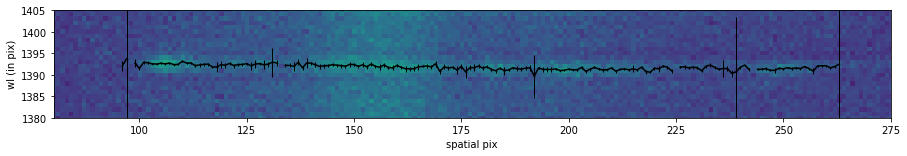

In [49]:
#in pixel space


y_unc_pixs = means_Wsigma_fullccd - gaussmeans_specpix_fullccd_MASKED #needed errors in pixs
subimg_fullccd =subimg2.data

vmin=-10
vmax=45
plt.figure(figsize=(15,20))
plt.imshow(subimg_fullccd.T,vmin=vmin,vmax=vmax)
plt.ylabel('wl (in pix)')
plt.xlabel('spatial pix')
plt.scatter(target_spacepix_fullccd,gaussmeans_specpix_fullccd_MASKED, marker='o',s=0.5,color='k')
plt.errorbar(target_spacepix_fullccd, gaussmeans_specpix_fullccd_MASKED, yerr=y_unc_pixs,elinewidth=1,color='k')
plt.ylabel('wl (in pix)')
plt.xlabel('spatial pix')
plt.ylim(1380,1405)
plt.xlim(80,275)

# removing uptick region (comoving group)

Model: eriksmodel
Inputs: ('r',)
Outputs: ('r',)
Model set size: 1
Parameters:
    r_cen alpha beta       sigma               omega       
    ----- ----- ---- ------------------ -------------------
      0.0 1e-07  1.0 -77.83449057506367 0.09892864276625842


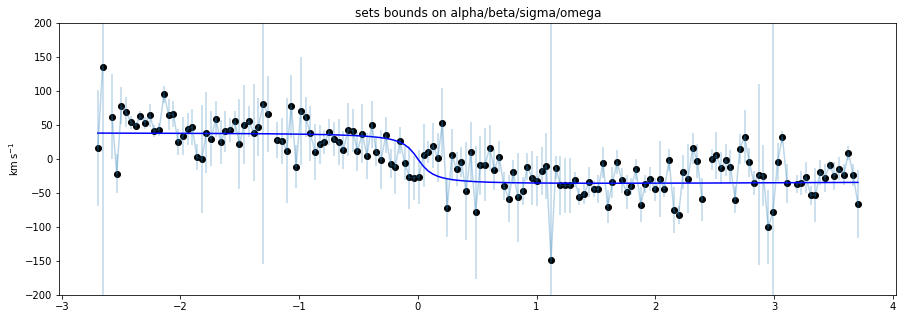

In [50]:
#uses core from sections & sets bounds
#eriks model eqt 5



@models.custom_model #very necessary line
def eriksmodel(r, r_cen=0, alpha=.00001, beta=.00001, sigma=-120, omega=.5):
    return (r * ((alpha + beta)/2) + (sigma - r*(alpha - beta)) * (np.arctan(r / omega))/np.pi)



#fit model to data
#m_init = eriksmodel()
m_init = eriksmodel(bounds={'alpha':(0.0000001,1), 'beta':(0.0000001,1),'sigma': (-300,300),'omega':(0,100)})

fit = fitting.LevMarLSQFitter()
nan_msk = ~np.isnan(v_unc)[:-6]
m = fit(m_init, arr(distances_sections[:-6])[nan_msk], arr(y_axis_Gvelocity.value[:-6])[nan_msk],weights=arr(1/(v_unc.value[:-6][nan_msk])**2))

print(m)

#plot data & fit
plt.figure(figsize=(15,5))
########################################################################
plt.scatter(distances_sections[:-6],y_axis_Gvelocity[:-6], color='k')
plt.errorbar(distances_sections[:-6], y_axis_Gvelocity[:-6], yerr=v_unc[:-6],alpha=.3)
########################################################################
plt.plot(distances_sections[:-6], m(distances_sections[:-6]), color='b')
plt.ylim(-200,200) #zooms to see data good, if fit is good
plt.title('sets bounds on alpha/beta/sigma/omega');

/Users/dee/miniconda3/lib/python3.6/site-packages/ipykernel_launcher.py:11: RuntimeWarning: divide by zero encountered in true_divide
  # This is added back by InteractiveShellApp.init_path()


<eriksmodel(r_cen=6.16969734, alpha=0.0000001, beta=1., sigma=-73.33126586, omega=0.13872978, v_offset=15.88942882)>


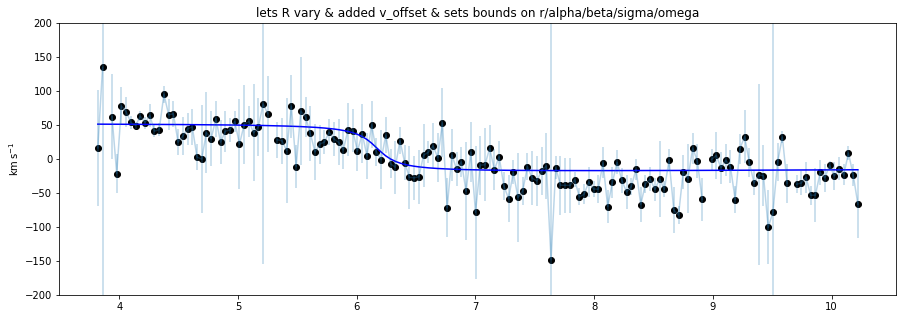

In [51]:
# added in a v-offset & dr b/c v-offset & BOUNDS ON ALPHA/BETA

#uses core from sections
#eriks model eqt 5



@models.custom_model #very necessary line
def eriksmodel(r,r_cen=0, alpha=.00001, beta=.00001, sigma=-120, omega=0.5,v_offset=0):#sigma=-200, omega=10
    dr = r-r_cen
    return (dr * ((alpha + beta)/2) + (sigma - dr*(alpha - beta)) * (np.arctan(dr / omega))/np.pi)+v_offset

# setting bounds
m_init = eriksmodel(bounds={'r_cen': (5,9), 'alpha':(.0000001,1), 'beta':(.0000001,1),'sigma': (-300,300),'omega':(0,100)})
m_init.r_cen=7

#fit model to data
fit = fitting.LevMarLSQFitter()
nan_msk = ~np.isnan(v_unc)[:-6]
m = fit(m_init, arr(distances_sections_target[:-6])[nan_msk], arr(y_axis_Gvelocity.value[:-6])[nan_msk],weights=arr(1/(v_unc.value[:-6][nan_msk])**2))

print(repr(m))

#plot data & fit
plt.figure(figsize=(15,5))
########################################################################
plt.scatter(distances_sections_target[:-6],y_axis_Gvelocity[:-6], color='k')
plt.errorbar(distances_sections_target[:-6], y_axis_Gvelocity[:-6], yerr=v_unc[:-6],alpha=.3)
########################################################################
plt.plot(distances_sections_target[:-6], m(distances_sections_target[:-6]), color='b')
plt.ylim(-200,200) #zooms to see data good, if fit is good
plt.title('lets R vary & added v_offset & sets bounds on r/alpha/beta/sigma/omega');

In [52]:
distances_sections[5:-9]

array([-2.49720249, -2.45742837, -2.41765426, -2.37788015, -2.33810603,
       -2.29833192, -2.2585578 , -2.21878369, -2.17900957, -2.13923546,
       -2.09946134, -2.05968723, -2.01991312, -1.980139  , -1.94036489,
       -1.90059077, -1.86081666, -1.82104254, -1.78126843, -1.74149432,
       -1.7017202 , -1.66194609, -1.62217197, -1.58239786, -1.54262374,
       -1.50284963, -1.46307551, -1.4233014 , -1.38352729, -1.34375317,
       -1.30397906, -1.26420494, -1.22443083, -1.18465671, -1.1448826 ,
       -1.10510848, -1.06533437, -1.02556026, -0.98578614, -0.94601203,
       -0.90623791, -0.8664638 , -0.82668968, -0.78691557, -0.74714146,
       -0.70736734, -0.66759323, -0.62781911, -0.588045  , -0.54827088,
       -0.50849677, -0.46872265, -0.42894854, -0.38917443, -0.34940031,
       -0.3096262 , -0.26985208, -0.23007797, -0.19030385, -0.15052974,
       -0.11075562, -0.07098151, -0.0312074 ,  0.00856672,  0.04834083,
        0.08811495,  0.12788906,  0.16766318,  0.20743729,  0.24

# USE BELOW FOR FINAL

/Users/dee/miniconda3/lib/python3.6/site-packages/ipykernel_launcher.py:11: RuntimeWarning: divide by zero encountered in true_divide
  # This is added back by InteractiveShellApp.init_path()


<eriksmodel(alpha=0.0000001, beta=1., sigma=-74.13208222, omega=0.13314854, v_offset=14.88019288)>


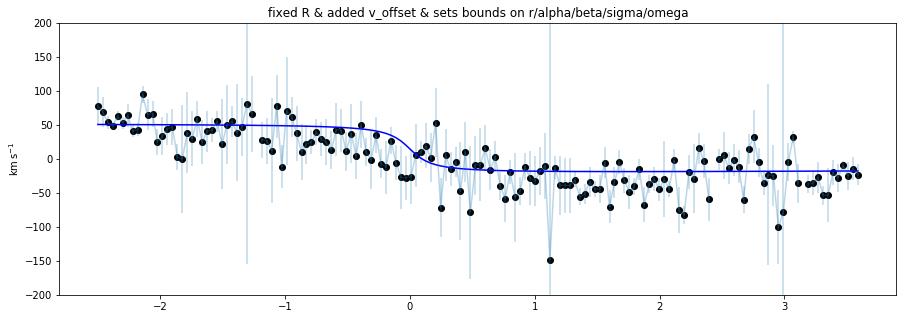

In [53]:
# added in a v-offset & dr b/c v-offset & BOUNDS ON ALPHA/BETA

#uses core from sections
#eriks model eqt 5



@models.custom_model #very necessary line
def eriksmodel(r, alpha=.00001, beta=.00001, sigma=-120, omega=0.5,v_offset=0):#sigma=-200, omega=10
    #dr = r-r_cen
    return (r * ((alpha + beta)/2) + (sigma - r*(alpha - beta)) * (np.arctan(r / omega))/np.pi)+v_offset

# setting bounds
m_init = eriksmodel(bounds={'alpha':(.0000001,1), 'beta':(.0000001,1),'sigma': (-300,300),'omega':(0,100)})
#m_init.r_cen=7

#playing with target cutout region used for fitting
start = int(5)
end = int(-9)

#fit model to data
fit = fitting.LevMarLSQFitter()
nan_msk = ~np.isnan(v_unc)[start:end]
mbest = fit(m_init, arr(distances_sections[start:end])[nan_msk], arr(y_axis_Gvelocity.value[start:end])[nan_msk],weights=arr(1/(v_unc.value[start:end][nan_msk])**2))

print(repr(mbest))

#plot data & fit
plt.figure(figsize=(15,5))
########################################################################
plt.scatter(distances_sections[start:end],y_axis_Gvelocity[start:end], color='k')
plt.errorbar(distances_sections[start:end], y_axis_Gvelocity[start:end], yerr=v_unc[start:end],alpha=.3)
########################################################################
plt.plot(distances_sections[start:end], mbest(distances_sections[start:end]), color='b')
plt.ylim(-200,200) #zooms to see data good, if fit is good
plt.title('fixed R & added v_offset & sets bounds on r/alpha/beta/sigma/omega');

In [54]:
# np.save('example2_CovMatrix/Gilgamesh1_x_axis_distances',distances_sections[start:end][nan_msk])
# np.save('example2_CovMatrix/Gilgamesh1_y_axis_velocities',y_axis_Gvelocity.value[start:end][nan_msk])
# np.save('example2_CovMatrix/Gilgamesh1_y_uncertainities',v_unc.value[start:end][nan_msk])

In [55]:
print('above 2 plots give similar outputs, r varies around the same region tho so thats good, sort of troubling that beta pushes to max lim & played with it but it will always push to max limit b/c the best fit is polynomial-like so not sure much will alter that b/c beyond original limits osciallations are crazy - just junk noise; so conclusion: use model values from above')

above 2 plots give similar outputs, r varies around the same region tho so thats good, sort of troubling that beta pushes to max lim & played with it but it will always push to max limit b/c the best fit is polynomial-like so not sure much will alter that b/c beyond original limits osciallations are crazy - just junk noise; so conclusion: use model values from above


In [56]:
# len(distances_sections),distances_sections

In [57]:
# len(distances_sections[0:-4]),distances_sections[0:-4]


# error bars on best fit model

In [58]:
#STEP 1  -- get distribution of each datapoint and name variables

#for analysis
xdata = arr(distances_sections[start:end])[nan_msk]
ydata_start = arr(y_axis_Gvelocity.value[start:end])[nan_msk] #arr(y_axis_Gvelocity_fromzoomed_means[:-1]) #.value to remove units
yerrdata = v_unc.value[start:end][nan_msk]#.value to removve units
#for plots
ydata_units = arr(y_axis_Gvelocity.value[start:end])[nan_msk]
yerr_units = v_unc.value[start:end][nan_msk]



print(len(xdata),len(ydata_start),len(yerrdata))#,len(ydata_final))

# create random value (from gauss distribution around datapt) to add to datapoint
normvals = [] #index per data value
ix = 0
for i in range(len(xdata)):
    npoints = len(xdata)
    ix +=1
    normdist = np.random.normal(ydata_start[i],abs(yerrdata[i]), 1000) #is yerrdata[i] sigma or std? - they are the same thing
    normvals.append(normdist)

### normvals is an array(len==lenofxdata) arrays(len==100) for each datapoint

151 151 151


In [59]:
#STEP 2 -- create bootstrap samples

sample_size = 1000 #generate 1000 new datasets
# final_xarrs = [] #always stays the same
final_yarrs = []
for val in range(sample_size): 
#     print(val)
    indices=[]
    for i in range(0,len(ydata_start)): #change 100 to len(ydata_start)
        indices.append(np.random.randint(0,(len(ydata_start)-1)))  #change 99 to (len(ydata_start)-1)
    #actually grabs the data based on those random points
    data_subset=xdata
    err_subset=[]

    for count,i in enumerate(indices):
#         print(count,i) #done with replacement
        mytest = normvals[count][i]
        err_subset.append(mytest)
    final_yarrs.append(err_subset)
np.shape(final_yarrs)

(1000, 151)

(1000, 151)


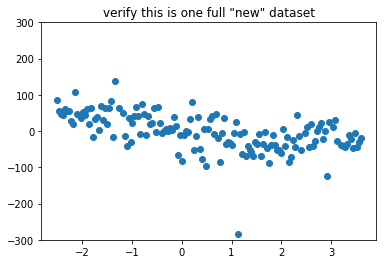

In [60]:
#replaces steps 1&2
data_matrix = []
for index in range(len(ydata_start)):
    data_matrix.append([np.random.normal(ydata_start[index], abs(yerrdata[index])) for i in range(1000)]) #generate 1000 new datasets
data_matrix = np.array(data_matrix).T
plt.scatter(xdata,data_matrix[80])
plt.title('verify this is one full "new" dataset')
plt.ylim(-300,300)
print(np.shape(data_matrix))

final_yarrs = data_matrix

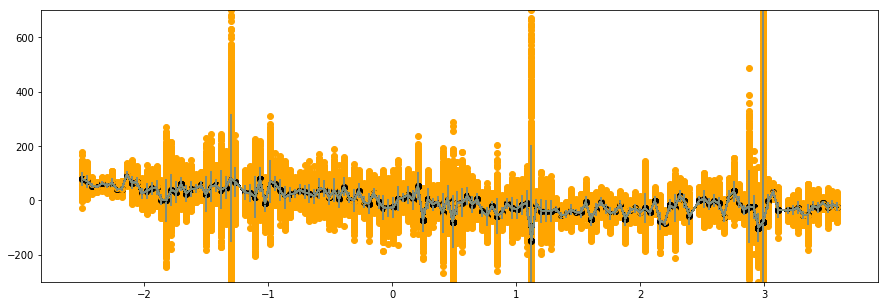

In [61]:
##STEP 3 --sanity check of new datasets


## plot all new datasets to see if scatter scales with errbars
plt.figure(figsize=(15,5))
for i in range(len(final_yarrs)):
    ###################################match names from best fit############################################
    plt.scatter(xdata, ydata_units, color='k')
    plt.errorbar(xdata,ydata_units,yerr=yerr_units,alpha=.3)
    #########################################################################################################
    plt.scatter(data_subset,final_yarrs[i], color='orange')
#     plt.legend() #cant use unless set up to only show once in this loop
#     plt.ylim(-200,200)
    plt.ylim(-300,700)

In [62]:
## STEP 4  --fits models (diff init params,weights) to each new dataset


###### OG -uses original inputs for init params
# def model
@models.custom_model #very necessary line
def ogeriksmodel(r,alpha=.00001, beta=.00001, sigma=-120, omega=0.5,v_offset=0):
    return (r * ((alpha + beta)/2) + (sigma - r*(alpha - beta)) * (np.arctan(r / omega))/np.pi) + v_offset
model_og = ogeriksmodel(bounds={'alpha':(.0000001,1), 'beta':(.0000001,1),'sigma': (-300,300),'omega':(0,100)})
#fit model to data in a loop
ogsigmas=[]
allogmodels=[]
for i in range(len(final_yarrs)):
    fit = fitting.LevMarLSQFitter()
    ogmodelfit = fit(model_og, data_subset, final_yarrs[i])
    allogmodels.append(ogmodelfit)
    ogsigmas.append(ogmodelfit.sigma.value)


###### REMIX -uses mbest for init params
# def model
@models.custom_model #very necessary line
def remixeriksmodel(r,alpha=mbest.alpha.value, beta=mbest.beta.value, sigma=mbest.sigma.value, omega=mbest.omega.value,v_offset=mbest.v_offset.value):#sigma=-200, omega=10
    return (r * ((alpha + beta)/2) + (sigma - r*(alpha - beta)) * (np.arctan(r / omega))/np.pi)+v_offset
model_wbest = remixeriksmodel(bounds={'alpha':(.0000001,1), 'beta':(.0000001,1),'sigma': (-300,300),'omega':(0,100)})
#fit model to data in a loop
remixsigmas=[]
allremixmodels=[]
for i in range(len(final_yarrs)):
    fit2 = fitting.LevMarLSQFitter()
    remixmodelfit = fit2(model_wbest, data_subset, final_yarrs[i])
    allremixmodels.append(remixmodelfit)
    remixsigmas.append(remixmodelfit.sigma.value)

    
    
##### WEIGHTS -redoing each model's fits with weights this time
#fit model to data in a loop
allogmodels_weight =[]
ogsigmas_weight =[]
allremixmodels_weight =[]
remixsigmas_weight =[]
for i in range(len(final_yarrs)):
    fit3 = fitting.LevMarLSQFitter()
    #remix
    remixmodelfit_weight = fit3(model_wbest, data_subset, final_yarrs[i],weights=(1/(yerrdata)**2))
    allremixmodels_weight.append(remixmodelfit_weight)
    remixsigmas_weight.append(remixmodelfit_weight.sigma.value)
    #og
    ogmodelfit_weight = fit3(model_og, data_subset, final_yarrs[i],weights=(1/(yerrdata)**2))
    allogmodels_weight.append(ogmodelfit_weight)
    ogsigmas_weight.append(ogmodelfit_weight.sigma.value)
    

/Users/dee/miniconda3/lib/python3.6/site-packages/ipykernel_launcher.py:8: RuntimeWarning: divide by zero encountered in true_divide
  
/Users/dee/miniconda3/lib/python3.6/site-packages/ipykernel_launcher.py:24: RuntimeWarning: divide by zero encountered in true_divide


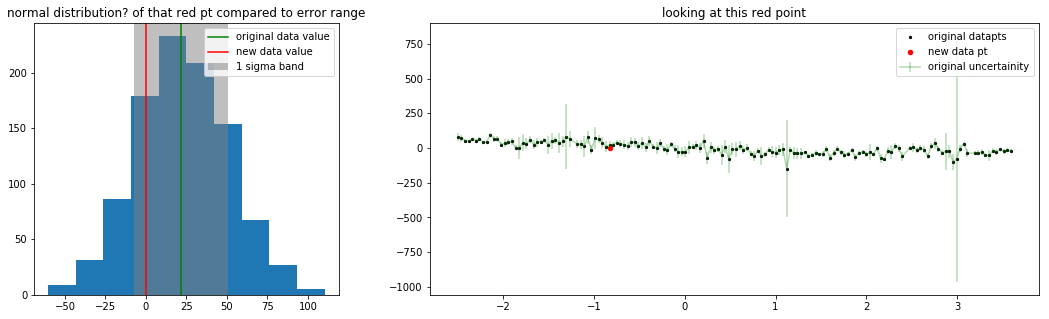

In [63]:
## Sanity check of new datapts wrt sigma range
# a test to see if new datapts lie within original errorbars


index = 41  # the index (of x-axis data) focusing on

singlept_dist = []
for count,alist in enumerate(final_yarrs):
    eachnewpt = alist[index]
    singlept_dist.append(eachnewpt)
    if count ==index:
        lookingat = alist[index]
    else:
        pass

f, (ax1, ax2) = plt.subplots(1, 2, figsize=(18,5), gridspec_kw={'width_ratios': [1, 2]})
ax1.hist(singlept_dist) 
# ax1.axvline(ydata_units[index],color='r',label='original data value')
ax1.axvline(ydata_units[index],color='green',label='original data value')
ax1.axvline(final_yarrs[index][index],color='r',label='new data value')


maxval = ydata_units[index]+abs(yerrdata[index])
minval = ydata_units[index]-abs(yerrdata[index])
ax1.axvspan(minval,maxval,facecolor='0.5', alpha=0.5,label='1 sigma band')
ax1.set_title('normal distribution? of that red pt compared to error range')
ax1.legend();

ax2.scatter(xdata,ydata_units,color='k',s=5,label='original datapts')
ax2.errorbar(xdata,ydata_units, yerr=yerr_units,alpha=.3,color='green',label='original uncertainity')
ax2.scatter(data_subset[index], final_yarrs[index][index],s=20,color='red',label='new data pt')
ax2.set_title('looking at this red point')
# ax2.set_ylim(-500,1000)
ax2.legend();
# print(ydata_units[index],lookingat,final_yarrs[index][index],v_unc[nan_msk2][index].value)
# print(len(ydata_units),len(yerrdata))

/Users/dee/miniconda3/lib/python3.6/site-packages/ipykernel_launcher.py:8: RuntimeWarning: divide by zero encountered in true_divide
  
/Users/dee/miniconda3/lib/python3.6/site-packages/ipykernel_launcher.py:24: RuntimeWarning: divide by zero encountered in true_divide


this is model fits from 1000 new datasets


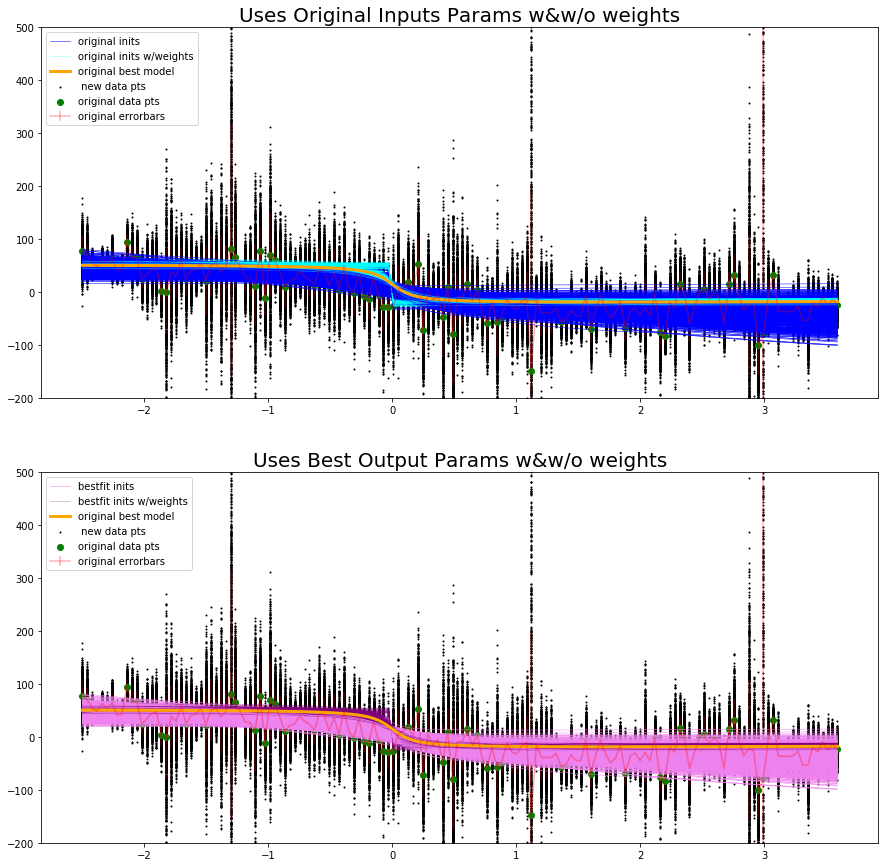

In [64]:
## STEP 5 -- plot model fits


## attempting to see many fits at once
# plt.figure(figsize=(15,5))
f, (ax1,ax2) = plt.subplots(2,1,figsize=(15,15))
for count in range(len(allogmodels)):
    colorval = count + 1 #b/c plt colors start at 1, no 0
    # conditional just to get one label for 100 new datasets
    if count == 0:
        ax1.plot(data_subset, allogmodels[count](data_subset), linewidth=.5,color='b',label='original inits') #OG
        ax2.plot(data_subset, allremixmodels[count](data_subset), linewidth=.5,color='violet',label='bestfit inits') #remix
        ax1.plot(data_subset, allogmodels_weight[count](data_subset), linewidth=.5,color='cyan',alpha=.5,label='original inits w/weights') #og-w
        ax2.plot(data_subset, allremixmodels_weight[count](data_subset), linewidth=.5,color='purple',alpha=.5,label='bestfit inits w/weights') #remix-w
        ax1.scatter(data_subset,final_yarrs[count],s=1, color='k',label=' new data pts')
        ax2.scatter(data_subset,final_yarrs[count],s=1, color='k',label=' new data pts')
    else:
        ax1.plot(data_subset, allogmodels[count](data_subset),linewidth=.5, color='b') #OG
        ax2.plot(data_subset, allremixmodels[count](data_subset), linewidth=.5,color='violet')#remix
        ax1.plot(data_subset, allogmodels_weight[count](data_subset), linewidth=.5,color='cyan',alpha=.5) #og-w
        ax2.plot(data_subset, allremixmodels_weight[count](data_subset), linewidth=.5,color='purple',alpha=.5)#remix-w
        ax1.scatter(data_subset,final_yarrs[count], s=1,color='k')#,linewidth=.2)
        ax2.scatter(data_subset,final_yarrs[count], s=1,color='k')#,linewidth=.2)
        
#####################################match names from best fit#########################################    
ax1.plot(xdata, mbest(xdata), linewidth = 3,color='orange',label='original best model')
ax1.errorbar(xdata,ydata_units, yerr=yerr_units,alpha=.3,color='red',label='original errorbars')
ax1.scatter(xdata, ydata_units,color='green',label='original data pts')

ax2.plot(xdata, mbest(xdata), linewidth = 3,color='orange',label='original best model')
ax2.errorbar(xdata,ydata_units, yerr=yerr_units,alpha=.3,color='red',label='original errorbars')
ax2.scatter(xdata, ydata_units,color='green',label='original data pts')
#########################################################################################################
ax1.legend()
ax2.legend()
ax1.set_title('Uses Original Inputs Params w&w/o weights',fontsize=20)
ax2.set_title('Uses Best Output Params w&w/o weights',fontsize=20)

ax1.set_ylim(-200,500);
ax2.set_ylim(-200,500); 
print('this is model fits from {} new datasets'.format(sample_size))

Do any of these sigma distributions look gaussian-like?


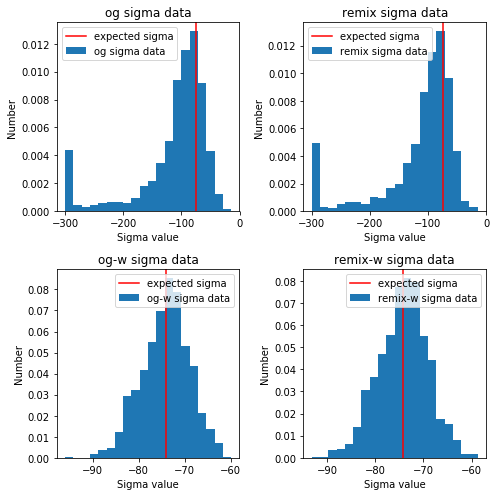

In [65]:
## STEP 6 --check sigmas for gaussian shape

f, ([ax1,ax2],[ax3,ax4]) = plt.subplots(2,2,figsize=(7,7))
extratick = [round(mbest.sigma.value,2)]
ax1.hist(ogsigmas, 20, density=True,label='og sigma data')
ax1.set_title('og sigma data')
ax3.hist(ogsigmas_weight, 20, density=True,label='og-w sigma data')
ax3.set_title('og-w sigma data')

ax2.hist(remixsigmas, 20, density=True,label='remix sigma data')
ax2.set_title('remix sigma data')
ax4.hist(remixsigmas_weight, 20, density=True,label='remix-w sigma data')
# ax4.set_xticklabels(list(ax4.xticks()[0]) + extratick)
ax4.set_title('remix-w sigma data')

axes = [ax1,ax2,ax3,ax4]
for i in axes:
    i.axvline(mbest.sigma.value,color='r',label='expected sigma')
    i.legend()
    i.set_ylabel('Number')
    i.set_xlabel('Sigma value');
f.tight_layout() 
print('Do any of these sigma distributions look gaussian-like?')

# extratick = [mbest.sigma.value]

In [66]:
#STEP 7 - get error values on sigma param of best fit

#error bars based on sigma percentiles - the best
#pick most gaussian looking sig distribution ##ogsigmas,ogsigmas_weight, remixsigmas,remixsigmas_weight
best_sig_dist = np.abs(remixsigmas_weight) #fit matches and dist looks most gauss

median = np.percentile(best_sig_dist,50)
upper = np.percentile(best_sig_dist,84)
lower = np.percentile(best_sig_dist,16)
upperlim = upper - median
lowerlim = median - lower
sigma_error = [upperlim,lowerlim]
print('model fit error for sigma param = ',sigma_error)



## w/o np.abs(): model fit error for sigma param =  [5.571468120902878, 5.533489582278918]
## with np.abs(): model fit error for sigma param =  [5.597857655117153, 4.693769878364023]
### using with for conssitency

model fit error for sigma param =  [5.597857655117153, 4.693769878364023]


# confusing old below

<eriksmodel(alpha=0.0000001, beta=1., sigma=-74.13208222, omega=0.13314854, v_offset=14.88019288)>


/Users/dee/miniconda3/lib/python3.6/site-packages/ipykernel_launcher.py:10: RuntimeWarning: divide by zero encountered in true_divide
  # Remove the CWD from sys.path while we load stuff.


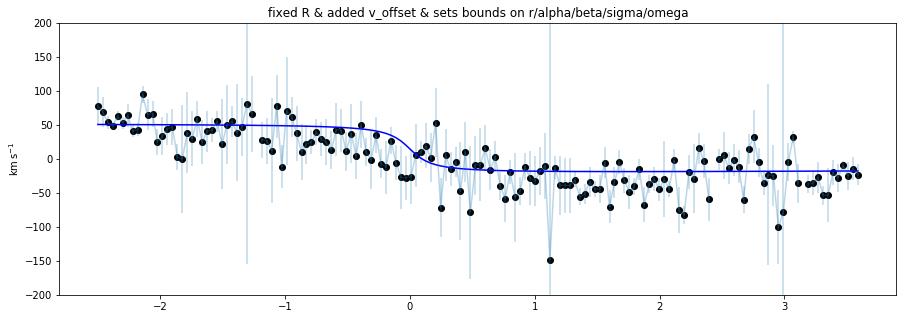

In [58]:
# # errrorbars ---free params best inits---didnt work


# # added in a v-offset & dr b/c v-offset & BOUNDS ON ALPHA/BETA
# #uses core from sections
# #eriks model eqt 5
# @models.custom_model #very necessary line
# def eriksmodel(r,alpha=mbest.alpha.value, beta=mbest.beta.value, sigma=mbest.sigma.value, omega=mbest.omega.value,v_offset=mbest.v_offset.value):#sigma=-200, omega=10
#     #dr = r-r_cen
#     return (r * ((alpha + beta)/2) + (sigma - r*(alpha - beta)) * (np.arctan(r / omega))/np.pi)+v_offset

# # setting bounds
# m_init = eriksmodel(bounds={'alpha':(.0000001,1), 'beta':(.0000001,1),'sigma': (-300,300),'omega':(0,100)})
# #m_init.r_cen=7

# #playing with target cutout region used for fitting
# start = int(5)
# end = int(-9)

# #fit model to data
# fit = fitting.LevMarLSQFitter()
# nan_msk = ~np.isnan(v_unc)[start:end]
# m = fit(m_init, arr(distances_sections[start:end])[nan_msk], arr(y_axis_Gvelocity.value[start:end])[nan_msk],weights=arr(1/(v_unc.value[start:end][nan_msk])**2))

# print(repr(m))

# #plot data & fit
# plt.figure(figsize=(15,5))
# ########################################################################
# plt.scatter(distances_sections[start:end],y_axis_Gvelocity[start:end], color='k')
# plt.errorbar(distances_sections[start:end], y_axis_Gvelocity[start:end], yerr=v_unc[start:end],alpha=.3)
# ########################################################################
# plt.plot(distances_sections[start:end], m(distances_sections[start:end]), color='b')
# plt.ylim(-200,200) #zooms to see data good, if fit is good
# plt.title('fixed R & added v_offset & sets bounds on r/alpha/beta/sigma/omega');

In [59]:
# print(fit.fit_info['param_cov'])

None


<eriksmodel(alpha=0.0000001, beta=1., sigma=-74.13208222, omega=0.13314854, v_offset=14.88019288)>


/Users/dee/miniconda3/lib/python3.6/site-packages/ipykernel_launcher.py:10: RuntimeWarning: divide by zero encountered in true_divide
  # Remove the CWD from sys.path while we load stuff.


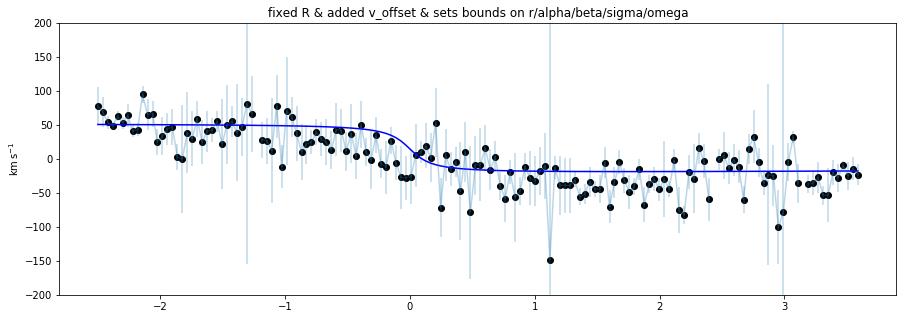

In [60]:
# # errrorbars ---forced params best inits---didnt work


# # added in a v-offset & dr b/c v-offset & BOUNDS ON ALPHA/BETA
# #uses core from sections
# #eriks model eqt 5
# @models.custom_model #very necessary line
# def eriksmodel(r,alpha=mbest.alpha.value, beta=mbest.beta.value, sigma=mbest.sigma.value, omega=mbest.omega.value,v_offset=mbest.v_offset.value):#sigma=-200, omega=10
#     #dr = r-r_cen
#     return (r * ((alpha + beta)/2) + (sigma - r*(alpha - beta)) * (np.arctan(r / omega))/np.pi)+v_offset

# # setting bounds
# m_init = eriksmodel(bounds={'alpha':(.0000001,1), 'beta':(.0000001,1),'sigma': (-300,300),'omega':(0,100)})
# #m_init.r_cen=7
# m_init.v_offset = mbest.v_offset.value
# m_init.sigma = mbest.sigma.value
# m_init.alpha = mbest.alpha.value
# m_init.beta = mbest.beta.value
# m_init.omega = mbest.omega.value

# #playing with target cutout region used for fitting
# start = int(5)
# end = int(-9)

# #fit model to data
# fit = fitting.LevMarLSQFitter()
# nan_msk = ~np.isnan(v_unc)[start:end]
# m = fit(m_init, arr(distances_sections[start:end])[nan_msk], arr(y_axis_Gvelocity.value[start:end])[nan_msk],weights=arr(1/(v_unc.value[start:end][nan_msk])**2))

# print(repr(m))

# #plot data & fit
# plt.figure(figsize=(15,5))
# ########################################################################
# plt.scatter(distances_sections[start:end],y_axis_Gvelocity[start:end], color='k')
# plt.errorbar(distances_sections[start:end], y_axis_Gvelocity[start:end], yerr=v_unc[start:end],alpha=.3)
# ########################################################################
# plt.plot(distances_sections[start:end], m(distances_sections[start:end]), color='b')
# plt.ylim(-200,200) #zooms to see data good, if fit is good
# plt.title('fixed R & added v_offset & sets bounds on r/alpha/beta/sigma/omega');

In [61]:
# mytab = Table([distances_sections[start:end],y_axis_Gvelocity[start:end],v_unc[start:end]])

In [62]:
# print(fit.fit_info['param_cov'])

None


# trying to get errorbars via bootstrap sampling

In [63]:
### outline steps
# create boot strap sample of datapoints


# fit model to each sample

# plot all sigma values to check for gaussian distribution

# FWHM to get 1 std (or variance?) and then sqrt it stuff like previous unc

In [64]:
#STEP 1

# check data structure for how many subsets to take

xdata = arr(distances_sections[start:end])[nan_msk]
ydata_start = arr(y_axis_Gvelocity.value[start:end])[nan_msk]
#################################################################################
############# if used commented out got wrong sigmas centered around -94 with virtual no errors;
##### if use uncommented get decent values and gaussian like around correct sigma of -74
#################################################################################
# yerrdata = arr(1/(v_unc.value[start:end][nan_msk])**2) #so its already sigma
yerrTEST = v_unc.value[start:end][nan_msk]
yerrdata =yerrTEST

print(len(xdata),len(ydata_start),len(yerrdata),len(yerrTEST))#,len(ydata_final))


# create random value (from gauss distribution around datapt) to add to datapoint
normvals = [] #index per data value
ix = 0
for i in range(len(xdata)):
    npoints = len(xdata)
    ix +=1
    normdist = np.random.normal(ydata_start[i],yerrdata[i], npoints) #is yerrdata[i] sigma or std? - they are the same thing
    normvals.append(normdist)

### normvals is an array(len==lenofxdata) arrays(len==100) for each datapoint

151 151 151 151


In [65]:
##checks of values

# ydata_start[0],yerrdata[0],normvals[0]
mytest = np.random.normal(ydata_start[3],yerrdata[3], 151)
mytest
print(ydata_start[3],yerrdata[3])
print(np.max(mytest)-np.min(mytest))

49.069693619931584 5.6283295948808085
31.558764457874815


expected. min: 43.441364025050774 max: 54.698023214812395
output  min: 33.90578877197617 max 63.33612676562995
this distribution is a bit wider than errors would expect but errors should have been the FWHM of a fit to this so using normal distribution will give lower tails at either end so i guess this is OK that it is wider??


((151, 151), 151, 5.6283295948808085)

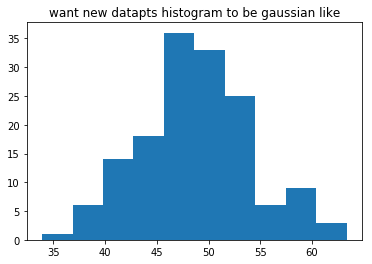

In [66]:
##sanity check

# check distribution of each new datapoint
index = 3
plt.hist(normvals[index])
# plt.scatter(78.0315,np.max(yerrdata))
# print(ydata_start[index])
print('expected. min:',ydata_start[index]-yerrdata[index], 'max:',ydata_start[index]+yerrdata[index])
print('output  min:',np.min(normvals[index]),'max',np.max(normvals[index]))
plt.title('want new datapts histogram to be gaussian like');
print('this distribution is a bit wider than errors would expect but errors should have \
been the FWHM of a fit to this so using normal distribution will give lower tails at either \
end so i guess this is OK that it is wider??')
np.shape(normvals),len(normvals[index]),yerrdata[index]

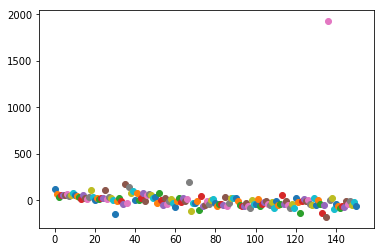

In [67]:
## sanity check that didnt help


# checking if new data retains err spread
for i in range(len(normvals)):
#     print(i)
    plt.scatter(i,normvals[i][3])

In [68]:
## random info

##how to find the std, std==sigma
# np.sqrt(np.sum((x[i]-mean)**2)/N)
## sigma is the sqrt of the variance

In [69]:
## dont think i need 

# checked the wrong thing- but keep code
#checking if "normal" data looks normal----oh wait, want gaussian of sigma values from fit to be gaussian


# # plt.plot(xdata,normvals[0])
# s = np.random.normal(ydata_start[0],yerrdata[0], len(ydata_start)) #yerrdata[0] #args==(mean,std,output_shape)
# count, bins, ignored = plt.hist(s, 30, density=True)
# #hist with prob.densityFCN
# plt.plot(bins, 1/(yerrdata[0] * np.sqrt(2 * np.pi)) *
#                np.exp( - (bins - ydata_start[0])**2 / (2 * yerrdata[0]**2) ),
#          linewidth=2, color='r');
# print('gaussian kinda?')

In [70]:
#not sure this is neede3d


# atest = v_unc.value[start:end][nan_msk] # bad test

# s = np.random.normal(ydata_start[0],atest, len(ydata_start)) #yerrdata[0] #args==(mean,std,output_shape)
# count, bins, ignored = plt.hist(s, 30, density=True)
# #hist with prob.densityFCN
# plt.plot(bins, 1/(yerrdata[0] * np.sqrt(2 * np.pi)) *
#                np.exp( - (bins - ydata_start[0])**2 / (2 * yerrdata[0]**2) ),
#          linewidth=2, color='r');


# atest[3],yerrdata[3]

In [71]:
#STEP 2

# GOOD create bootstrap sampling


# final_xarrs = [] #always stays the same
final_yarrs = []
for val in range(1000): #generate 1000 new datasets
#     print(val)
    indices=[]
    for i in range(0,len(ydata_start)): #change 100 to len(ydata_start)
        indices.append(np.random.randint(0,(len(ydata_start)-1)))  #change 99 to (len(ydata_start)-1)
    #actually grabs the data based on those random points
    data_subset=xdata
    err_subset=[]

    for count,i in enumerate(indices):
#         print(count,i) #done with replacement
        mytest = normvals[count][i]
        err_subset.append(mytest)
    final_yarrs.append(err_subset)
np.shape(final_yarrs)

(1000, 151)

In [72]:
# ## sanity check--same as above one its ok

# plt.hist(normvals[40]) #each new datapt is a normal dist-good
# plt.title('want new data points to look gaussian');
# # normvals[0]

In [73]:
#checking values

# len(indices),
# #compare original y-values to final_yarrs
# ydata_start[0:20], final_yarrs[0][0:20],np.where(yerrdata==np.max(yerrdata)),yerrdata[3]

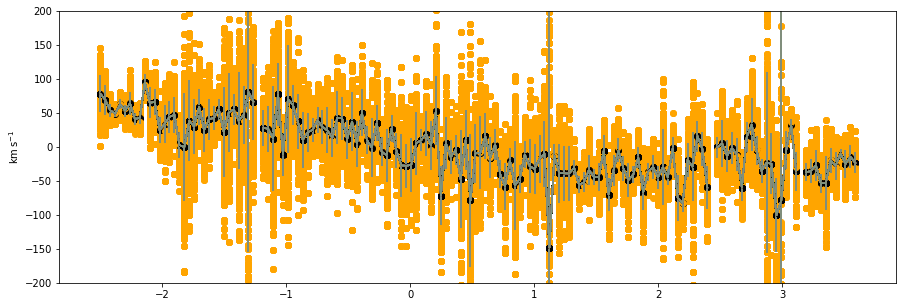

In [74]:
##STEP 3 --sanity check 


## plot all new datasets to see if scatter scales with errbars


# np.shape(data_subset),np.shape(err_subset),err_subset,data_subset
# for i in range(len(labels_subset)):
#     print(labels_subset[i])
#     break
plt.figure(figsize=(15,5))
for i in range(len(final_yarrs)):
    plt.scatter(distances_sections[start:end],y_axis_Gvelocity[start:end], color='k')
    plt.errorbar(distances_sections[start:end], y_axis_Gvelocity[start:end], yerr=v_unc[start:end],alpha=.3)
    plt.scatter(data_subset,final_yarrs[i], color='orange')
    plt.ylim(-200,200)

#### USES ORIGINAL INPUT INIT PARAMS

In [75]:
## STEP--4

# fit model for each sample
#og
# def model
@models.custom_model #very necessary line
def eriksmodel(r, alpha=.00001, beta=.00001, sigma=-120, omega=0.5,v_offset=0):#sigma=-200, omega=10
    return (r * ((alpha + beta)/2) + (sigma - r*(alpha - beta)) * (np.arctan(r / omega))/np.pi)+v_offset
model_init = eriksmodel(bounds={'alpha':(.0000001,1), 'beta':(.0000001,1),'sigma': (-300,300),'omega':(0,100)})

sigmas=[]
allmodels=[]
#fit model to data in a loop
for i in range(len(final_yarrs)):
    fit = fitting.LevMarLSQFitter()
    modelfit = fit(model_init, data_subset, final_yarrs[i])
    allmodels.append(modelfit)
    sigmas.append(modelfit.sigma.value)
#   print(repr(modelfit))
print('This cell used eriksmodel with the same init params that started the original best fit')

/Users/dee/miniconda3/lib/python3.6/site-packages/ipykernel_launcher.py:8: RuntimeWarning: divide by zero encountered in true_divide
  


This cell used eriksmodel with the same init params that started the original best fit


/Users/dee/miniconda3/lib/python3.6/site-packages/ipykernel_launcher.py:8: RuntimeWarning: divide by zero encountered in true_divide
  


this is model fits from 100 new datasets


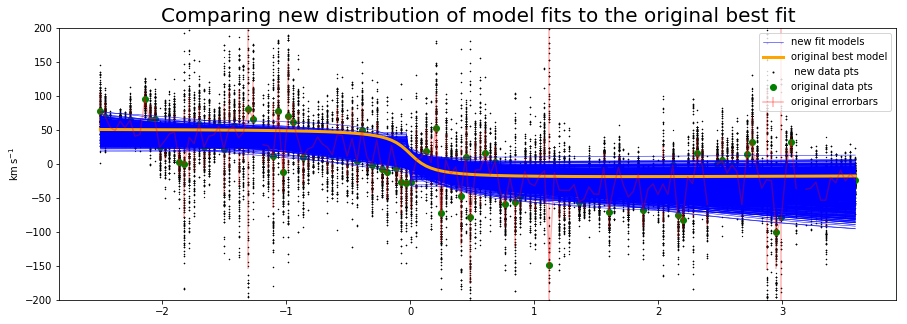

In [76]:
## STEP - 5
## sanity check -- used same init params that got og best fit

# sigmas #expected to be around -74 but these are around -91

## attempting to see many fits at once
plt.figure(figsize=(15,5))
for count,model in enumerate(allmodels):
    colorval = count + 1 #b/c plt colors start at 1, no 0
    # conditional just to get one label for 100 new datasets
    if count == 0:
        plt.plot(data_subset, model(data_subset), linewidth=.5,color='b',label='new fit models')
        plt.scatter(data_subset,final_yarrs[count],s=1, color='k',label=' new data pts')
    else:
        plt.plot(data_subset, model(data_subset),linewidth=.5, color='b')
        plt.scatter(data_subset,final_yarrs[count], s=1,color='k',linewidth=.2)
plt.plot(distances_sections[start:end], mbest(distances_sections[start:end]), linewidth = 3,color='orange',label='original best model')
plt.errorbar(distances_sections[start:end], y_axis_Gvelocity[start:end], yerr=v_unc[start:end],alpha=.3,color='red',label='original errorbars')
plt.scatter(distances_sections[start:end], y_axis_Gvelocity[start:end],color='green',label='original data pts')
plt.legend()
plt.title('Comparing new distribution of model fits to the original best fit',fontsize=20)
plt.ylim(-200,200); 
print('this is model fits from 100 new datasets')

USES MODEL WITH INIT PARAMS THAT GOT OG BEST FIT


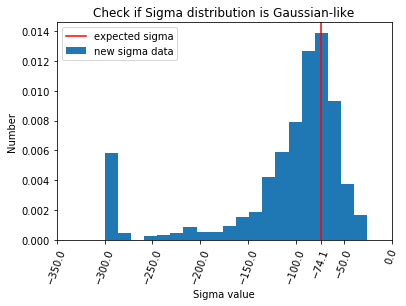

In [77]:
## STEP -6

#check if sigma distribution is gaussian -like

# plot sigma distribution
counts, bins, ignored = plt.hist(sigmas, 20, density=True,label='new sigma data')
plt.axvline(mbest.sigma.value,color='r',label='expected sigma')
extratick = [mbest.sigma.value]
plt.xticks(list(plt.xticks()[0]) + extratick,rotation=70)
plt.legend()
plt.ylabel('Number')
plt.title('Check if Sigma distribution is Gaussian-like')
plt.xlabel('Sigma value');
# print('Expected value of sigma from best fit:',mbest.sigma.value)
print('USES MODEL WITH INIT PARAMS THAT GOT OG BEST FIT')

#### USES OUTPUT BEST PARAMS

In [78]:
# remix of above to see if diff init vals matter
# fit model for each sample

# def model
@models.custom_model #very necessary line
def eriksmodel(r, alpha=mbest.alpha.value, beta=mbest.beta.value, sigma=mbest.sigma.value, omega=mbest.omega.value,v_offset=mbest.v_offset.value):#sigma=-200, omega=10
    return (r * ((alpha + beta)/2) + (sigma - r*(alpha - beta)) * (np.arctan(r / omega))/np.pi)+v_offset
model_init = eriksmodel(bounds={'alpha':(.0000001,1), 'beta':(.0000001,1),'sigma': (-300,300),'omega':(0,100)})

sigmas2=[]
allmodels2=[]
#fit model to data in a loop
for i in range(len(final_yarrs)):
    fit = fitting.LevMarLSQFitter()
    modelfit2 = fit(model_init, data_subset, final_yarrs[i])
    allmodels2.append(modelfit2)
    sigmas2.append(modelfit2.sigma.value)
#   print(repr(modelfit))
print('This cell used eriks model with init params == the output best params from original best fit')

/Users/dee/miniconda3/lib/python3.6/site-packages/ipykernel_launcher.py:7: RuntimeWarning: divide by zero encountered in true_divide
  import sys


This cell used eriks model with init params == the output best params from original best fit


/Users/dee/miniconda3/lib/python3.6/site-packages/ipykernel_launcher.py:7: RuntimeWarning: divide by zero encountered in true_divide
  import sys


this is model fits from 100 new datasets


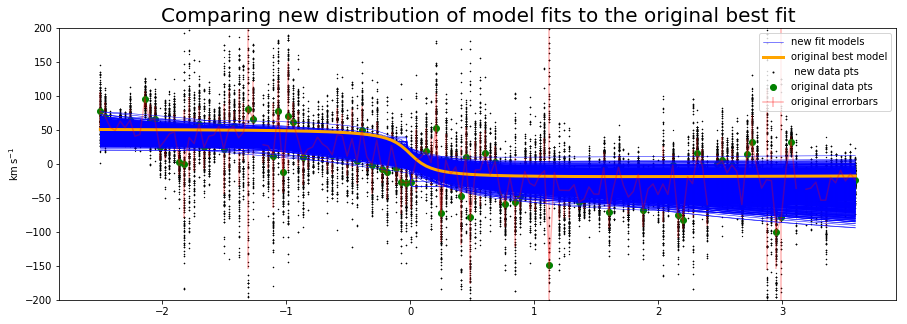

In [79]:
## sanity check -- used output params from og best fit

# sigmas #expected to be around -74 but these are around -91

## attempting to see many fits at once
plt.figure(figsize=(15,5))
for count,model in enumerate(allmodels2):
    colorval = count + 1 #b/c plt colors start at 1, no 0
    # conditional just to get one label for 100 new datasets
    if count == 0:
        plt.plot(data_subset, model(data_subset), linewidth=.5,color='b',label='new fit models')
        plt.scatter(data_subset,final_yarrs[count],s=1, color='k',label=' new data pts')
    else:
        plt.plot(data_subset, model(data_subset),linewidth=.5, color='b')
        plt.scatter(data_subset,final_yarrs[count], s=1,color='k',linewidth=.2)
plt.plot(distances_sections[start:end], mbest(distances_sections[start:end]), linewidth = 3,color='orange',label='original best model')
plt.errorbar(distances_sections[start:end], y_axis_Gvelocity[start:end], yerr=v_unc[start:end],alpha=.3,color='red',label='original errorbars')
plt.scatter(distances_sections[start:end], y_axis_Gvelocity[start:end],color='green',label='original data pts')
plt.legend()
plt.title('Comparing new distribution of model fits to the original best fit',fontsize=20)
plt.ylim(-200,200); 
print('this is model fits from 100 new datasets')

USES MODEL WITH OUTPUT PARAMS FROM OG BEST FIT


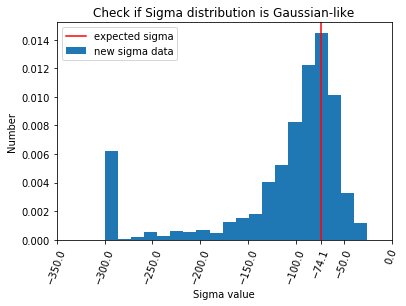

In [80]:
#check if sigma distribution is gaussian -like

# plot sigma distribution
counts2, bins2, ignored2 = plt.hist(sigmas2, 20, density=True,label='new sigma data')
plt.axvline(mbest.sigma.value,color='r',label='expected sigma')
extratick = [mbest.sigma.value]
plt.xticks(list(plt.xticks()[0]) + extratick,rotation=70)
plt.legend()
plt.ylabel('Number')
plt.title('Check if Sigma distribution is Gaussian-like')
plt.xlabel('Sigma value');
# print('Expected value of sigma from best fit:',mbest.sigma.value)
print('USES MODEL WITH OUTPUT PARAMS FROM OG BEST FIT')

not much diff btwn two sets of initial parameter values for fitting model


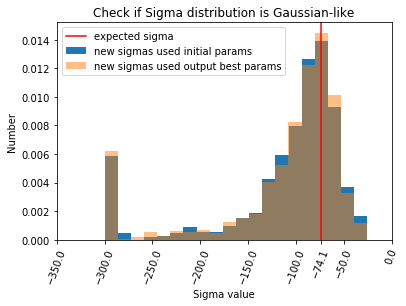

In [81]:
#comparing two ways of doing model fit 

# plot sigma distribution
counts, bins, ignored = plt.hist(sigmas, 20, density=True,label='new sigmas used initial params')
counts2, bins2, ignored2 = plt.hist(sigmas2, 20, alpha=.5,density=True,label='new sigmas used output best params')


plt.axvline(mbest.sigma.value,color='r',label='expected sigma')
extratick = [mbest.sigma.value]
plt.xticks(list(plt.xticks()[0]) + extratick,rotation=70)
plt.legend()
plt.ylabel('Number')
plt.title('Check if Sigma distribution is Gaussian-like')
plt.xlabel('Sigma value');
# print('Expected value of sigma from best fit:',mbest.sigma.value)
print('not much diff btwn two sets of initial parameter values for fitting model')

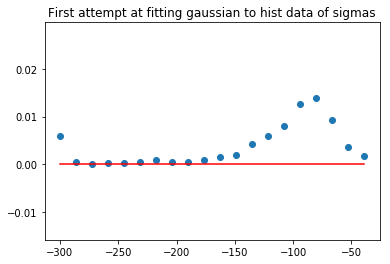

In [82]:
# STEP - 7

### fit gaussian to sigma distribution to get FWHM----attempt #1


plt.scatter(bins[:-1],counts) #x,y
#fit gaussian
model_gauss = models.Gaussian1D()
fitter_gauss = fitting.LevMarLSQFitter()
best_fit_gauss = fitter_gauss(model_gauss, bins[:-1], counts) #model,x,y,weights
#plot fit
plt.plot(bins[:-1],best_fit_gauss(bins[:-1]),color='r')
plt.title('First attempt at fitting gaussian to hist data of sigmas');

idk why this wont work


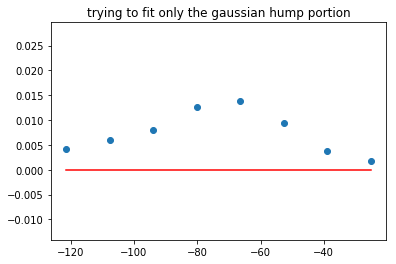

In [83]:
### fit gaussian to sigma distribution to get FWHM----attempt #2


#only fit the really gauss looking part
plt.scatter(bins[13::],counts[12::]) #x,y
#fit gaussian
model_gauss = models.Gaussian1D()
fitter_gauss = fitting.LevMarLSQFitter()
best_fit_gauss = fitter_gauss(model_gauss, bins[13::], counts[12::]) #model,x,y,weights
#plot fit
plt.plot(bins[13::],best_fit_gauss(bins[13::]),color='r')
plt.title('trying to fit only the gaussian hump portion');
# len(bins[12::]),len(counts[11::])
print('idk why this wont work')

# left off here: was trying to get gaussian fit but its a waste of time
# move on to test fits on other targets to check if they replicate 
# best fit with new data distribution values
## also check the remix values when creating new datasets b/c mbest inits or original inits dont seem to affect at all but print out new sigmas and subtract arrays to see how diff the fits are
## also check if the error values are consistent and changing or not b/c some places hsould have higher scatter than they are in the resulting new datasets -- plot new and og datasets overlaid to see if places with high err have more scatter than tighter regions of small err

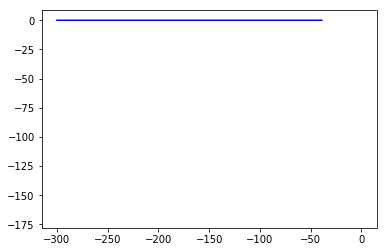

In [84]:
#original data
plt.plot(bins[:-1],counts,color='b')
#fit gaussian
model_gauss = models.Gaussian1D()
fitter_gauss = fitting.LevMarLSQFitter()
best_fit_gauss = fitter_gauss(model_gauss,  counts, bins[:-1])
#plot fit
# plt.plot(bins[:-1],best_fit_gauss(bins[:-1]),color='r')
plt.plot(counts,best_fit_gauss(counts),color='r')

In [85]:
len(sigmas)

1000

In [86]:
print('sigmas:',sigmas)
print('count:',count)
print('bins:', bins)
print('ignored:', ignored)

sigmas: [-247.7341756989938, -55.369250309902334, -87.1902906308449, -84.80741103882625, -94.83441594698816, -87.52954778178312, -69.1645201672035, -79.69929235812265, -75.80932706737575, -101.007439134932, -65.30184920035782, -300.0, -103.55658743530952, -61.28061155040868, -56.20248273771371, -93.61118473258436, -108.14542136450409, -146.5625611149148, -52.787611949386054, -228.13462562530458, -85.73109306765133, -136.79511288845345, -63.60963125502163, -25.306648008746524, -44.64236186837708, -76.7331825025976, -152.56304032195115, -96.35932105642442, -40.085848874949576, -112.14635663806853, -80.03125537332258, -68.63168415173624, -99.91494934904053, -52.746543233235926, -77.03517547347661, -112.26046684971556, -100.84433685066887, -87.60770810313224, -79.92216894674574, -47.82649881771438, -78.60526088819293, -81.42298410157429, -94.18573547697528, -78.75181713379997, -203.20615549848975, -141.74998072078188, -69.19774009321497, -71.45427235476515, -83.11657644327481, -76.45710255

Parameter('amplitude', value=1.0) Parameter('stddev', value=1.0, bounds=(1.1754943508222875e-38, None)) Model: Gaussian1D
Inputs: ('x',)
Outputs: ('y',)
Model set size: 1
Parameters:
    amplitude mean stddev
    --------- ---- ------
          1.0  0.0    1.0


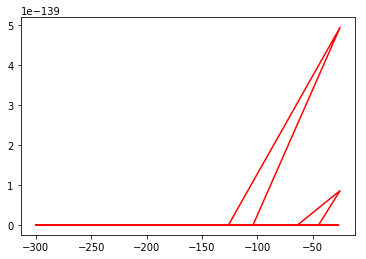

In [87]:
#try to fit a gaussian to sigma



from astropy.modeling.models import Gaussian1D
plt.figure()
s1 = Gaussian1D()
r = np.histogram(sigmas)
r=sigmas
plt.plot(r, s1(r),color='r')
print(s1.amplitude,s1.stddev,s1)
# plt.hist(r,50);

In [88]:
s1(r)

array([0.00000000e+000, 0.00000000e+000, 0.00000000e+000, 0.00000000e+000,
       0.00000000e+000, 0.00000000e+000, 0.00000000e+000, 0.00000000e+000,
       0.00000000e+000, 0.00000000e+000, 0.00000000e+000, 0.00000000e+000,
       0.00000000e+000, 0.00000000e+000, 0.00000000e+000, 0.00000000e+000,
       0.00000000e+000, 0.00000000e+000, 0.00000000e+000, 0.00000000e+000,
       0.00000000e+000, 0.00000000e+000, 0.00000000e+000, 8.57367361e-140,
       0.00000000e+000, 0.00000000e+000, 0.00000000e+000, 0.00000000e+000,
       0.00000000e+000, 0.00000000e+000, 0.00000000e+000, 0.00000000e+000,
       0.00000000e+000, 0.00000000e+000, 0.00000000e+000, 0.00000000e+000,
       0.00000000e+000, 0.00000000e+000, 0.00000000e+000, 0.00000000e+000,
       0.00000000e+000, 0.00000000e+000, 0.00000000e+000, 0.00000000e+000,
       0.00000000e+000, 0.00000000e+000, 0.00000000e+000, 0.00000000e+000,
       0.00000000e+000, 0.00000000e+000, 0.00000000e+000, 0.00000000e+000,
       0.00000000e+000, 0

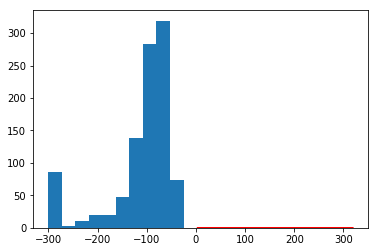

In [89]:
# np.histogram(sigmas)
atest = plt.hist(sigmas)
r=atest[0]
plt.plot(r, s1(r),color='r')
# plt.hist(r,50);

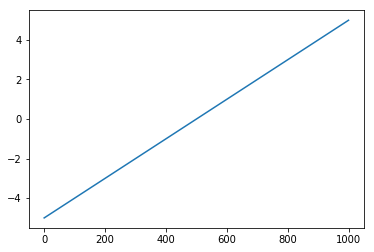

In [90]:
r = np.arange(-5, 5, .01)
r
# sigmas
plt.plot(r)

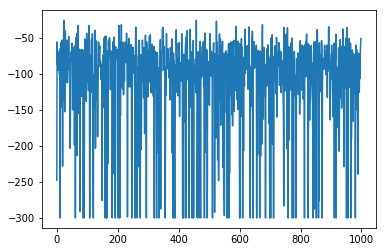

In [91]:
plt.plot(sigmas)

but crap, sigma should be around -74 but its not! why????


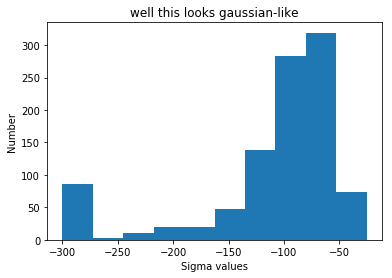

In [92]:
plt.hist(sigmas)
plt.ylabel('Number')
plt.xlabel('Sigma values')
plt.title('well this looks gaussian-like');
print('but crap, sigma should be around -74 but its not! why????')

In [93]:
# from tree import build_tree, print_tree, car_data, car_labels
# import random
# random.seed(4)

# tree = build_tree(car_data,car_labels)
# #print_tree(tree)

# #######this part does the bagging
# #gets random points to split on
# indices=[]
# for i in range(0,1000):
#   indices.append(random.randint(0,999))  
# #actually grabs the data based on those random points
# data_subset=[]
# labels_subset=[]
# for i in indices:
#   data_subset.append(car_data[i])
#   labels_subset.append(car_labels[i])
# ##############end of bagging

# #this part sees one of the trees, if ran above again then this, would get a diff tree
# subset_tree = build_tree(data_subset,labels_subset)
# print_tree(subset_tree)

# --------------------OLD BELOW THIS-------------------